_______________________________________
_______________________________________
# <u>NAPAS data summary + analysis</u>


In [3]:
PYTHONPATH="${PYTHONPATH}:/usr/local/lib/python3.6/dist-packages/"

In [4]:
!pip install statsmodels --upgrade

In [5]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# data wrangling
import pandas as pd
import json, csv, os, re
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# mathematics
from math import floor, ceil, log10

# forecasting
from keras.layers.core import Dense, Dropout, Activation
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import sklearn.preprocessing as prep

# LSTM forecasting
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# miscellaneous
from sys import exit
from datetime import datetime, date
from random import random

### **IMPORTING CSV files**

### *Change here*
Importing num csv num file (SLGD) and val file (GTGD) here.

```
os.path.join("file directory", "csv_file.csv")
```
To get *file directory*, right click on the file and choose "**Copy path**". The csv file must follow the given format.

In [7]:
# NUM (SLGD) for 1 year
df_atm_num = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_NUM_2021.csv'))
num_atm_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_NUM_2021.csv'))[0]

# VAL (GTGD) for 1 year
df_atm_val = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_VAL_2021.csv'))
val_atm_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_VAL_2021.csv'))[0]

# NUM (SLGD) for 2 years (previous and current, i.e. 2021 and 2022 till May)
df_num_both = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_NUM_BOTH_2022.csv'))
num_both_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_NUM_BOTH_2022.csv'))[0]

# VAL (GTGD) for 2 years (previous and current)
df_val_both = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_VAL_BOTH_2022.csv'))
val_both_name = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_VAL_BOTH_2022.csv'))[0]

# # NUM or VAL of previous 2 years and current year
# df_2prev = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_NUM_2PREV.csv'))
# name_2prev = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_NUM_2PREV.csv'))[0]

# NUM or VAL of previous 4 years and current year
df_2prev = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_NUM_4PREV.csv'))
name_2prev = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_NUM_4PREV.csv'))[0]

# NUM (SLGD) of current year (this year would be 2022)
df_curr_num = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_NUM_2022.csv'))

# Yearly summary file
df_sum = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'blah.csv'))

df_2prev = pd.read_csv(os.path.join("/content/drive/MyDrive/ATM", 'ATM_ISS_NUM_4DATE.csv'))
name_2prev = os.path.splitext(os.path.basename('/content/drive/MyDrive/ATM/ATM_ISS_NUM_4PREV.csv'))[0]

### **Specifying bank to be forecasted**

### *Change here*
Bank specified as abbrieviated code (i.e. 'BIDV').

In [8]:
bank_name = 'BIDV'

### **Specifying periodicity & starting point of prediction**

### *Change here*
-- `periodicity` (in a year) can be 'month', 'year', 'day', 'week', etc.

-- `start_pred` has to be in this format: 'Mmm dd YYYY' (i.e. Jan 2 2022)

-- `furthest_av` also same format.

<u>Note:</u> `start_pred` cannot exceed `furthest_av`.

(i.e. `furthest_av = 'Apr 1 2022'` then `start_pred` must be before, or at least on the same date, like `'Mar 3 2022'`).

In [9]:
periodicity = 'month'
start_pred = 'Feb 1 2022'
furthest_av = 'Apr 1 2022'


#### **Some streamlining steps** (retrieving service name and year)

In [10]:
# helper function
def nameyear(name):
    for i in range(len(name)):
        if name[i] == "_":
            break
    count = 0
    for j in reversed(range(len(name))):
        if name[j] == "_":
            count = j+1
            break
        
    service = name[:i]
    year = name[count:]
    return [service, year]

# NUM 1 year
serviceyear = nameyear(num_atm_name)
num_atm_service = serviceyear[0]
num_atm_year = serviceyear[1]

# VAL 1 year
serviceyear = nameyear(val_atm_name)
val_atm_service = serviceyear[0]
val_atm_year = serviceyear[1]

# NUM 2 years
serviceyear = nameyear(num_both_name)
num_both_service = serviceyear[0]
num_both_year = int(serviceyear[1])

# VAL 2 years
serviceyear = nameyear(val_both_name)
val_both_service = serviceyear[0]
val_both_year = int(serviceyear[1])

# 2prev
pattern_2prev = r'(\w+)_(\w+)_(\w+)_(\w+)'
if re.findall(pattern_2prev, name_2prev)[0][2] == 'NUM':
    type_2prev = "number of transactions"
else:
    type_2prev = "value of transactions"
service_2prev = re.findall(pattern_2prev, name_2prev)[0][0]

# periodicity
if periodicity == 'month':
    time_per = 12
elif periodicity == 'week':
    time_per = 52
elif periodicity == 'quarter':
    time_per = 4
else:
    time_per = -1

# starting prediction point
start_pred = pd.Timestamp(datetime.strptime(start_pred, '%b %d %Y').date())
furthest_av = pd.Timestamp(datetime.strptime(furthest_av, '%b %d %Y').date())

# change leftmost_num depending on context
leftmost_num = 0

For the '*previous 2 years*' category, it can be changed freely to 3 or whatever number of years desired, as long as it follows the exact format.

For other categories however, specified requirements must be met.

### **CSV file modification steps**

In [11]:
df_sum.set_index('DV', inplace=True)
df_sum.index.name = None
df_sum.head()

,2015,2016,2017,2018,2019,2020,2021,2022_(May)
ATM,"158,955,252","184,436,916","191,352,006","241,587,725","291,384,377","310,493,140","296,673,651","129,631,538"
POS,"6,146,929","10,619,200","25,835,874","27,812,889","42,775,512","55,812,843","63,928,550","31,060,066"
IBFT,"1,968,044","6,067,623","22,025,695","100,334,140","335,798,236","827,601,412","1,858,083,514","1,352,553,709"
International,"1,002,622","1,657,806","1,997,948","1,890,459","1,433,385","603,027","365,834","112,211"
EcomND,"2,005,536","2,751,460","4,262,985","7,325,012","12,005,768","15,815,587","57,455,455","26,391,901"


**Checking for attributes with wrongly assigned data types**

In [12]:
for j in range(df_sum.shape[1]): # iterate over columns
    try:
        a = df_sum.iloc[leftmost_num,j]+1
    except:
        if len(df_sum.columns[j]) >= 7:
            print(df_sum.columns[j], "\t", df_sum.iloc[leftmost_num,j],
                "\t",type(df_sum.iloc[leftmost_num,j]))
        else:
            print(df_sum.columns[j], "\t\t", df_sum.iloc[leftmost_num,j],
                "\t",type(df_sum.iloc[leftmost_num,j]))

2015 		 158,955,252 	 <class 'str'>
2016 		 184,436,916 	 <class 'str'>
2017 		 191,352,006 	 <class 'str'>
2018 		 241,587,725 	 <class 'str'>
2019 		 291,384,377 	 <class 'str'>
2020 		 310,493,140 	 <class 'str'>
2021 		 296,673,651 	 <class 'str'>
2022_(May) 	 129,631,538 	 <class 'str'>


**Converting to appropriate numerical values**

In [13]:
df_sum.replace(',','', regex=True, inplace=True)

col_index = 0
for i in df_sum.columns:
    if (df_sum[i].dtypes == object) & (col_index >= leftmost_num):
        df_sum[i] = df_sum[i].astype('float')
    else:
        df_sum[i] = df_sum[i]
    col_index += 1

print(df_sum.dtypes)

2015          float64
2016          float64
2017          float64
2018          float64
2019          float64
2020          float64
2021          float64
2022_(May)    float64
dtype: object


**Showing ugly dataframe**

In [14]:
# showing only first few records
df_sum.head()

,2015,2016,2017,2018,2019,2020,2021,2022_(May)
ATM,158955252.0,184436916.0,191352006.0,241587725.0,291384377.0,310493140.0,2.966737e+08,1.296315e+08
POS,6146929.0,10619200.0,25835874.0,27812889.0,42775512.0,55812843.0,6.392855e+07,3.106007e+07
IBFT,1968044.0,6067623.0,22025695.0,100334140.0,335798236.0,827601412.0,1.858084e+09,1.352554e+09
International,1002622.0,1657806.0,1997948.0,1890459.0,1433385.0,603027.0,3.658340e+05,1.122110e+05
EcomND,2005536.0,2751460.0,4262985.0,7325012.0,12005768.0,15815587.0,5.745546e+07,2.639190e+07


In [15]:
df_yearly = df_sum.T
df_yearly

,ATM,POS,IBFT,International,EcomND,EcomQT,Topup,Billing,Paylater
2015,158955252.0,6146929.0,1.968044e+06,1002622.0,2005536.0,NaN,4617976.0,890970.0,249557.0
2016,184436916.0,10619200.0,6.067623e+06,1657806.0,2751460.0,2022194.0,5762144.0,1428962.0,323013.0
2017,191352006.0,25835874.0,2.202570e+07,1997948.0,4262985.0,2604050.0,9451278.0,3320013.0,699891.0
2018,241587725.0,27812889.0,1.003341e+08,1890459.0,7325012.0,2319300.0,4257070.0,2942997.0,434426.0
2019,291384377.0,42775512.0,3.357982e+08,1433385.0,12005768.0,6792781.0,5653639.0,4371575.0,441901.0
2020,310493140.0,55812843.0,8.276014e+08,603027.0,15815587.0,8986351.0,9235716.0,5684876.0,486765.0
2021,296673651.0,63928550.0,1.858084e+09,365834.0,57455455.0,5786709.0,14968100.0,6008922.0,301797.0
2022_(May),129631538.0,31060066.0,1.352554e+09,112211.0,26391901.0,2064702.0,8060390.0,2516943.0,205702.0


### **/// <u>IMPORTANT:</u> RUN ALL CELLS FROM THIS PART TO ABOVE ONLY WHENEVER CHANGING PARAMETERS**
### Other dataframes:

**"Num 1 year" dataframe**

In [16]:
# modifying dataframe and extracting some info
df_atm_num.set_index('TCTV', inplace=True)
df_atm_num.index.name = None

# similarly, coverting to correct data type
df_atm_num = df_atm_num.replace(np.nan,0)
df_atm_num.replace(',','', regex=True, inplace=True)
df_atm_num.replace('-','0', regex=True, inplace=True)

col_index = 0
for i in df_atm_num.columns:
    if (df_atm_num[i].dtypes == object) & (col_index >= leftmost_num):
        df_atm_num[i] = df_atm_num[i].astype('float')
    col_index += 1

df_atm_num.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ABB,138989.0,135100.0,123107.0,132129.0,122105.0,113773.0,107304.0,84703.0,89423.0,118801.0,120028.0,128202.0
ACB,813875.0,760277.0,739926.0,774595.0,713785.0,643866.0,563105.0,453426.0,487122.0,648962.0,685073.0,700766.0
BAB,37491.0,27683.0,30102.0,33031.0,28818.0,28072.0,26998.0,23231.0,24574.0,31221.0,30626.0,28782.0
BIDV,3732541.0,3163675.0,3149690.0,3440912.0,3166393.0,2973866.0,2791285.0,2214357.0,2325761.0,2987379.0,3106570.0,3152600.0
BVB,76819.0,53327.0,61283.0,63999.0,56016.0,54841.0,52522.0,39298.0,41615.0,53004.0,53249.0,55292.0


**"Val 1 year" dataframe**

In [17]:
# modifying dataframe
df_atm_val.set_index('TCTV', inplace=True)
df_atm_val.index.name = None

# similarly, coverting to correct data type
df_atm_val = df_atm_val.replace(np.nan,0)
df_atm_val.replace(',','', regex=True, inplace=True)
df_atm_val.replace('-','0', regex=True, inplace=True)

col_index = 0
for i in df_atm_val.columns:
    if (df_atm_val[i].dtypes == object) & (col_index >= leftmost_num):
        df_atm_val[i] = df_atm_val[i].astype('float')
    col_index += 1

df_atm_val.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
ABB,2.374094e+11,2.658225e+11,2.063544e+11,2.293022e+11,2.066647e+11,1.922758e+11,1.884238e+11,1.496792e+11,1.570077e+11,1.987842e+11,1.950158e+11,2.192900e+11
ACB,1.307124e+12,1.417698e+12,1.166695e+12,1.244170e+12,1.136775e+12,1.036105e+12,9.476647e+11,7.862088e+11,8.505057e+11,1.061095e+12,1.098911e+12,1.130426e+12
BAB,6.848464e+10,5.595550e+10,5.556033e+10,6.144337e+10,5.171556e+10,5.061588e+10,4.893864e+10,4.440986e+10,4.626331e+10,5.786258e+10,5.449984e+10,5.265013e+10
BIDV,6.199566e+12,6.093696e+12,5.081767e+12,5.623950e+12,5.185993e+12,4.925063e+12,4.737470e+12,3.797757e+12,3.988215e+12,4.910969e+12,5.071594e+12,5.281567e+12
BVB,1.507259e+11,1.077459e+11,1.142405e+11,1.217836e+11,1.018314e+11,1.009584e+11,9.880474e+10,7.328585e+10,7.820328e+10,9.761937e+10,9.667395e+10,1.014739e+11


**"Num both" dataframe**

In [18]:
df_num_both.set_index('TCTV', inplace=True)
df_num_both.index.name = None

# similarly, coverting to correct data type
df_num_both = df_num_both.replace(np.nan,0)
df_num_both.replace(',','', regex=True, inplace=True)
df_num_both.replace('-','0', regex=True, inplace=True)

col_index = 0
for i in df_num_both.columns:
    if (df_num_both[i].dtypes == object) & (col_index >= leftmost_num):
        df_num_both[i] = df_num_both[i].astype('float')
        col_index += 1
    else:
        col_index += 1

# find upper_num_whole
upper_num_whole = max([df_num_both.iloc[i].max() for i in range(len(df_num_both))])

# showing dataframe
df_num_both.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan_curr,Feb_curr,Mar_curr,Apr_curr
ABB,138989.0,135100.0,123107.0,132129.0,122105.0,113773.0,107304.0,84703.0,89423.0,118801.0,120028.0,128202.0,163622.0,89126.0,120885.0,133727.0
ACB,813875.0,760277.0,739926.0,774595.0,713785.0,643866.0,563105.0,453426.0,487122.0,648962.0,685073.0,700766.0,938933.0,501129.0,701287.0,724716.0
BAB,37491.0,27683.0,30102.0,33031.0,28818.0,28072.0,26998.0,23231.0,24574.0,31221.0,30626.0,28782.0,39075.0,15112.0,27460.0,29328.0
BIDV,3732541.0,3163675.0,3149690.0,3440912.0,3166393.0,2973866.0,2791285.0,2214357.0,2325761.0,2987379.0,3106570.0,3152600.0,4218984.0,2135402.0,3161277.0,3407338.0
BVB,76819.0,53327.0,61283.0,63999.0,56016.0,54841.0,52522.0,39298.0,41615.0,53004.0,53249.0,55292.0,68044.0,32035.0,47374.0,49980.0


**"Val both" dataframe**

In [19]:
# modifying df
df_val_both.set_index('TCTV', inplace=True)
df_val_both.index.name = None

# similarly, coverting to correct data type
df_val_both = df_val_both.replace(np.nan,0)
df_val_both.replace(',','', regex=True, inplace=True)
df_val_both.replace('-','0', regex=True, inplace=True)

col_index = 0
for i in df_val_both.columns:
    if (df_val_both[i].dtypes == object) & (col_index >= leftmost_num):
        df_val_both[i] = df_val_both[i].astype('float')
    col_index += 1

df_val_both.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan_curr,Feb_curr,Mar_curr,Apr_curr
ABB,2.374094e+11,2.658225e+11,2.063544e+11,2.293022e+11,2.066647e+11,1.922758e+11,1.884238e+11,1.496792e+11,1.570077e+11,1.987842e+11,1.950158e+11,2.192900e+11,3.154198e+11,1.550871e+11,2.056002e+11,2.336220e+11
ACB,1.307124e+12,1.417698e+12,1.166695e+12,1.244170e+12,1.136775e+12,1.036105e+12,9.476647e+11,7.862088e+11,8.505057e+11,1.061095e+12,1.098911e+12,1.130426e+12,1.716373e+12,8.197734e+11,1.106399e+12,1.164350e+12
BAB,6.848464e+10,5.595550e+10,5.556033e+10,6.144337e+10,5.171556e+10,5.061588e+10,4.893864e+10,4.440986e+10,4.626331e+10,5.786258e+10,5.449984e+10,5.265013e+10,7.867219e+10,2.691192e+10,5.160109e+10,5.263438e+10
BIDV,6.199566e+12,6.093696e+12,5.081767e+12,5.623950e+12,5.185993e+12,4.925063e+12,4.737470e+12,3.797757e+12,3.988215e+12,4.910969e+12,5.071594e+12,5.281567e+12,8.021531e+12,3.565728e+12,5.088249e+12,5.595653e+12
BVB,1.507259e+11,1.077459e+11,1.142405e+11,1.217836e+11,1.018314e+11,1.009584e+11,9.880474e+10,7.328585e+10,7.820328e+10,9.761937e+10,9.667395e+10,1.014739e+11,1.370280e+11,5.892616e+10,8.594145e+10,9.413555e+10


**Currently available data of the year dataframe**

In [20]:
# modifying
df_curr_num = df_curr_num.set_index('DV')
df_curr_num.index.name = None
df_curr_num.replace(',','', regex=True, inplace=True)
df_curr_num.replace('-','0', regex=True, inplace=True)

# converting to correct data type
col_index = 0
for i in df_curr_num.columns:
    if (df_curr_num[i].dtypes == object) & (col_index >= leftmost_num):
        df_curr_num[i] = df_curr_num[i].astype('float')
    else:
        df_curr_num[i] = df_curr_num[i]
    col_index += 1

# will use this as test set
df_curr_num.head()

,Jan,Feb,Mar,Apr
ABB,163622.0,89126.0,120885.0,133727.0
ACB,938933.0,501129.0,701287.0,724716.0
BAB,39075.0,15112.0,27460.0,29328.0
BIDV,4218984.0,2135402.0,3161277.0,3407338.0
BVB,68044.0,32035.0,47374.0,49980.0


**"n previous year" dataframe**

In [21]:
# modifying
df_2prev = df_2prev.set_index('DV').T
df_2prev.index.name = None
df_2prev.replace(',','', regex=True, inplace=True)
df_2prev.replace('-','0', regex=True, inplace=True)

# converting to correct data type
col_index = 0
for i in df_2prev.columns:
    if (df_2prev[i].dtypes == object) & (col_index >= leftmost_num):
        df_2prev[i] = df_2prev[i].astype('float')
    else:
        df_2prev[i] = df_2prev[i]
    col_index += 1

df_2prev.index = pd.to_datetime(df_2prev.index)

# will use this as test set
df_2prev.head()

DV,ABB,ACB,BAB,BIDV,BVB,COB,VCR,DAB,EIB,GPB,...,VB,VBARD,VCB,VCCB,VIB,VPB,VRB,KBHN,KBHCM,WRB
2018-01-01,126305.0,403334.0,24107.0,1880396.0,72856.0,1463.0,0.0,1215242.0,309511.0,16293.0,...,NaN,2578116.0,5480948.0,22315.0,399639.0,481455.0,34759.0,NaN,NaN,NaN
2018-02-01,138918.0,429177.0,27754.0,1965665.0,66455.0,1320.0,0.0,1329118.0,333523.0,14730.0,...,NaN,1570812.0,5703320.0,25983.0,484784.0,475055.0,40975.0,NaN,NaN,NaN
2018-03-01,120212.0,377578.0,25362.0,1716604.0,63068.0,1225.0,0.0,1003001.0,291414.0,15990.0,...,NaN,2127132.0,4796334.0,23874.0,374136.0,465886.0,35029.0,NaN,NaN,NaN
2018-04-01,119667.0,403327.0,29248.0,1838451.0,65505.0,1664.0,91.0,1029486.0,293549.0,16948.0,...,NaN,2215662.0,4994993.0,23283.0,387514.0,494367.0,36746.0,NaN,NaN,NaN
2018-05-01,112625.0,407343.0,24225.0,1852418.0,62219.0,1250.0,125.0,1023246.0,277865.0,16781.0,...,NaN,2183958.0,4936067.0,18691.0,387223.0,507297.0,35879.0,NaN,NaN,NaN


**Find first periods (for streamlining)**

In [82]:
# helper function
def findfirst(df):
    i = len(df.columns)-1
    while re.findall('_curr', df.columns[i]):
        i = i-1
    return df.columns[i+1]

# NUM both
num_first_period = findfirst(df_num_both)

# VAL both
val_first_period = findfirst(df_val_both)

### /// **END**

_______________________________________
_______________________________________
# <u>Data Summary via visualization</u>

## **NUM (SLGD)**
_______________________________________

In [23]:
# Number of ATM issuers
print("SL ngân hàng ISS (ATM):", df_atm_num.shape[0])

SL ngân hàng ISS (ATM): 49


In [24]:
# helper conversion function
millnames = ['','k',' mil',' bil',' tril']

def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(floor(0 if n == 0 else log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

### **Getting periodicity + Visualizing trend of NUM from each bank**

In [25]:
len(df_atm_num) == df_atm_num.shape[0]

True

In [26]:
# graphing function returning number of rows and plots per row
def numrow(df):
    num_bank = df.shape[0]
    # getting number of rows for graph
    num_row = 1
    if 4 <= num_bank < 9:
        num_row = 2
    elif 9 <= num_bank < 19:
        num_row = 3
    elif 19 <= num_bank < 53:
        num_row = 4
    else:
        num_row = 5
    return num_row

def rowplot(df):
    num_bank = df.shape[0]
    num_row = numrow(df)
    # getting horizontal axes
    if num_bank % num_row: # This is only to ensure streamline
        horizontal_axes = ceil(num_bank/num_row)
    else:
        horizontal_axes = int(num_bank/num_row)
    return horizontal_axes

In [27]:
# PLOTTING FUNCTION: SINGLE NUM/VAL
# parameters = [
    # df:         dataframe
    # service:    dataframe's column (ATM, IBFT, etc.)
    # year:       year corresponding to data
    # dtype:      'NUM', 'VAL', 'NUM_BOTH', or 'VAL_BOTH'
    # ptype:      'uniform' or 'individual'
# ]

def nv1_plot(df, service, year, dtype, ptype):
    upper = max([df.iloc[i].max() for i in range(len(df))])
    num_row = numrow(df)
    horizontal_axes = rowplot(df)
    
    # line color
    if dtype == 'NUM' or dtype == 'NUM_BOTH':
        cl = 'blue'
        first_period = num_first_period
    elif dtype == 'VAL' or dtype == 'VAL_BOTH':
        cl = 'red'
        first_period = val_first_period
    else:
        cl = 'orange'
        dtype = 'N/A'

    # uniform or individual scale y-axis?
    if ptype == 'uniform':
        fig, ax = plt.subplots(
            num_row, horizontal_axes, figsize=(30,15), sharey=True, sharex=True)
    else:
        fig, ax = plt.subplots(num_row, horizontal_axes, figsize=(30,15))

    # period
    if 'BOTH' in dtype:
        whole_period = df.columns
        fig.suptitle("Comparative plot for {}'s {} ({} scale) in {} and {}".format(
            service, dtype, ptype, year-1, year), size=35)
    else:
        fig.suptitle("Distribution of {}'s {} transactions ({}) for each ISS ({} scale)".format(
            service, dtype, year, ptype), size=35)

    k = 0
    for i in range(num_row):
        for j in range(horizontal_axes):
            try:
                y = df.iloc[i*horizontal_axes+j]

                # for 'both' df
                if 'BOTH' in dtype:
                    ax[i, j].plot(whole_period, y, color=cl)
                    ax[i, j].plot(np.where(y==0,y,None), color="white")
                    ax[i, j].axvline(x=first_period, color='lime', linestyle='--')
                    ax[i, j].set_title(df.T.columns[k], fontsize=17)
                    if ptype == 'uniform':
                        ax[i, j].set_ylim(bottom=-1, top=upper)
                    else:
                        ax[i, j].set_ylim(bottom=-1)

                # for 'single' df
                else:
                    ax[i, j].plot(np.where(y>=0,y,None), color=cl)
                    ax[i, j].plot(np.where(y<=0,y,None), color="white")
                    if ptype == 'uniform':
                        ax[i, j].set_ylim(bottom=-1, top=upper)
                    else:
                        ax[i, j].set_ylim(bottom=-1)
                    ax[i, j].set_title(df.T.columns[k], fontsize=17)

                # for the 2 types
                ax[i, j].tick_params(axis='y', which='both', labelsize=13)
                ax[i, j].tick_params(axis='x', which='both', labelbottom=False)

                # uniform ticks will appear, otherwise not
                if ptype == 'uniform':
                    ax[i, j].ticklabel_format(useOffset=False, style='plain', axis='y')
                    ticks_loc = ax[i, j].get_yticks().tolist()
                    ax[i, j].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
                    ax[i, j].set_yticklabels([millify(x) for x in ticks_loc])
                else:
                    ax[i, j].set_yticks([])

                k += 1
            except:
                k += 1
                ax[i, j].tick_params(axis='x', which='both', labelbottom=False)
                if ptype != 'uniform':
                    ax[i, j].set_yticks([])

    fig.text(0.5, 0.04, 'time period', ha='center', size=25)
    if 'BOTH' in dtype:
        imp_line = Line2D([0], [0], label='{} of transactions'.format(dtype), color=cl)
        year_line = Line2D([0], [0], label="line separating {} and {}".format(
            year-1, year), color='lime', linestyle='--')
        handles = [imp_line, year_line]
        fig.legend(handles=handles, loc='upper right', prop={'size': 19})
    fig.show()

**Plot:**

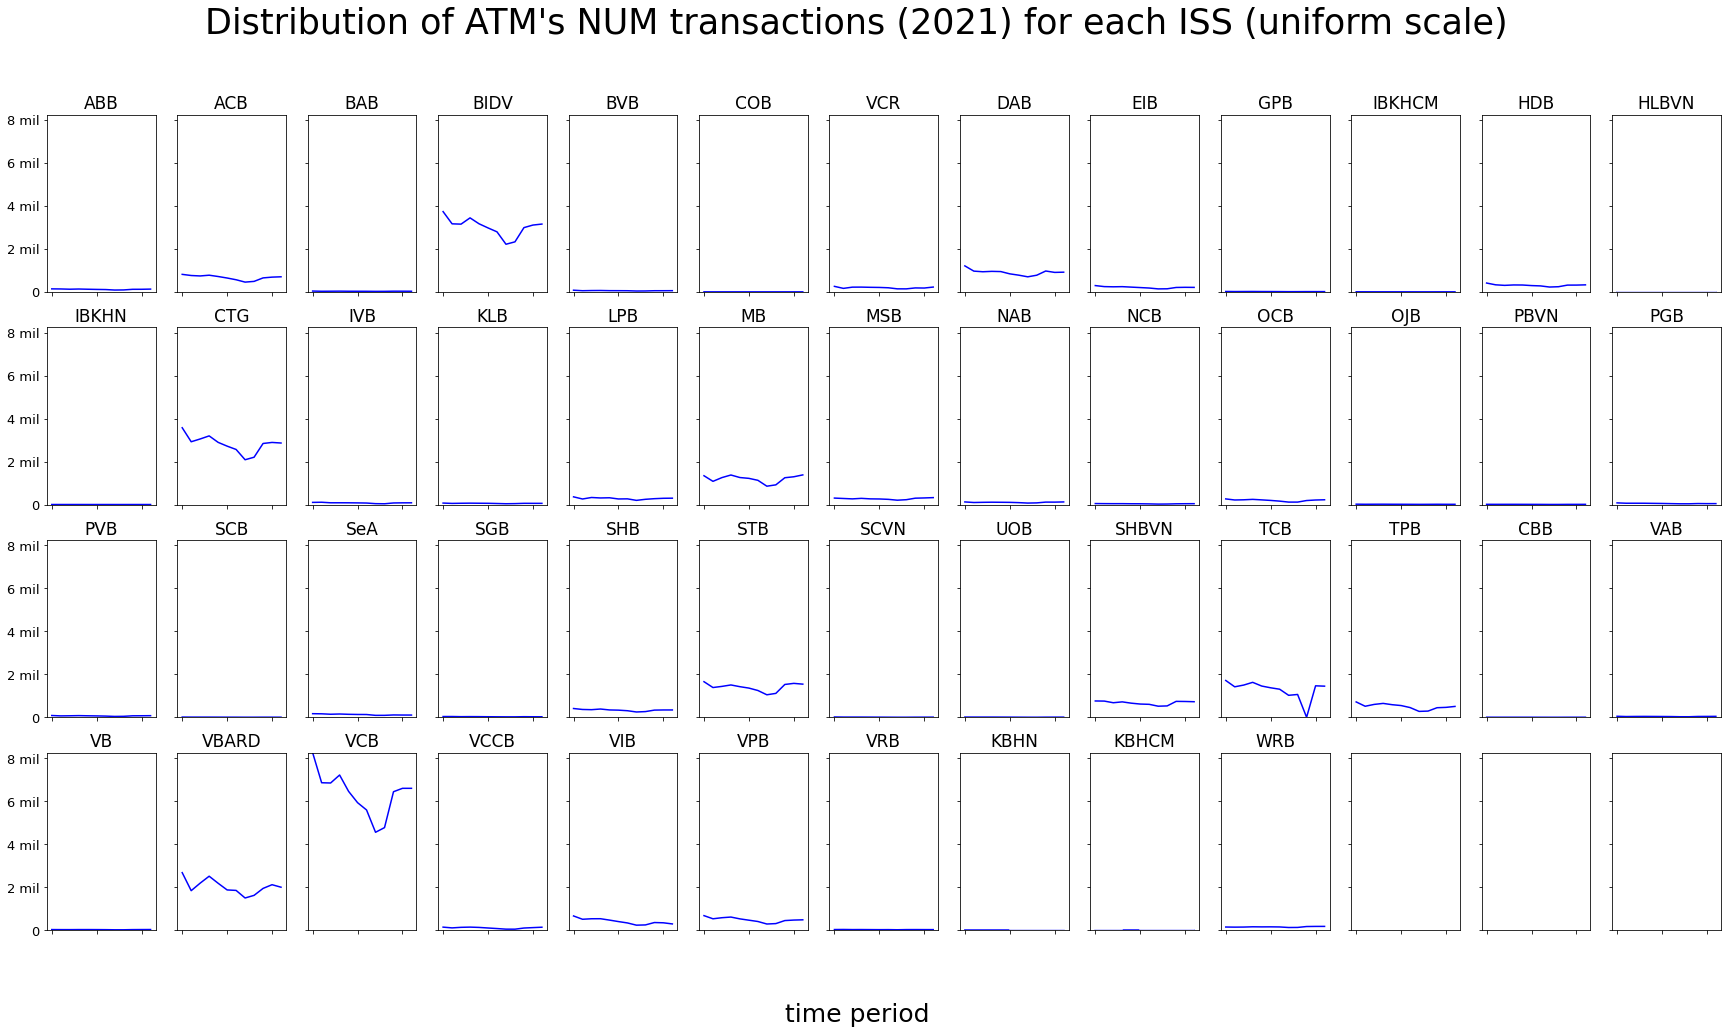

In [28]:
nv1_plot(df_atm_num, num_atm_service, num_atm_year, 'NUM', 'uniform')

## **VAL (GTGD)**

**Plot:**

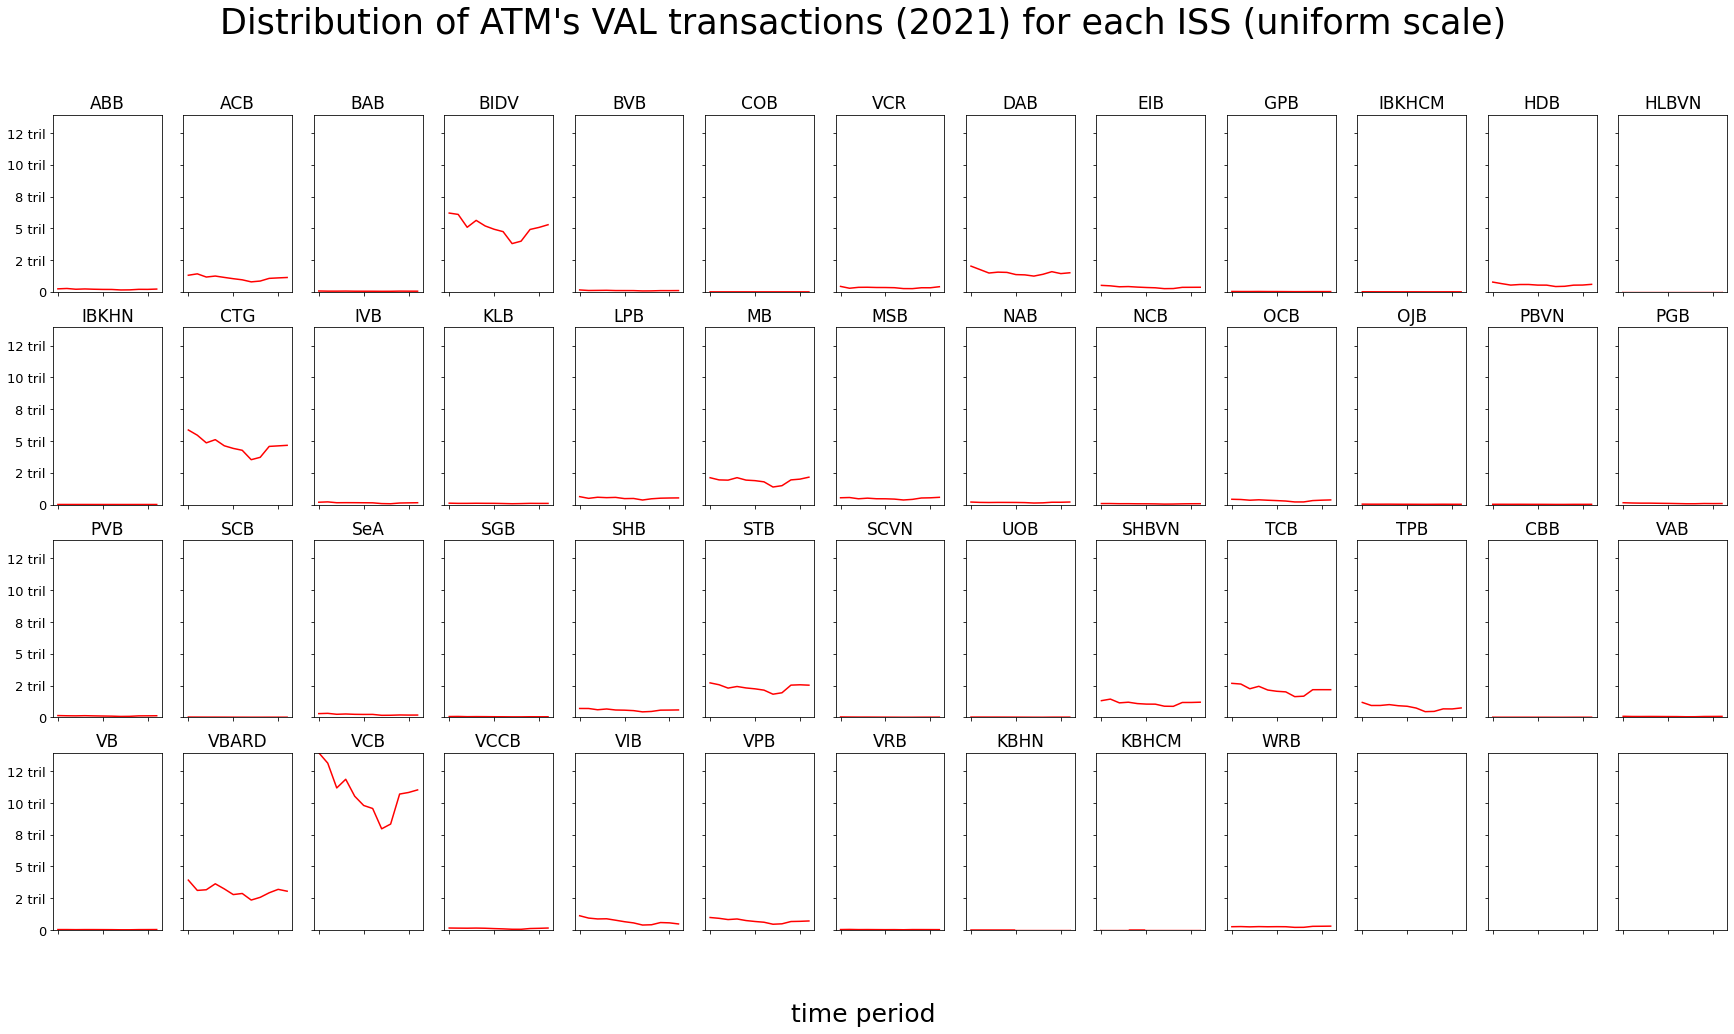

In [29]:
nv1_plot(df_atm_val, val_atm_service, val_atm_year, 'VAL', 'uniform')

## **Service NUM as compared to VAL**
### (uniform scale for each)

In [30]:
# PLOTTING FUNCTION: COMPARATIVE
# parameters = [
    # df_num:     num dataframe
    # df_val:     val dataframe
    # service:    dataframe's column (ATM, IBFT, etc.)
    # year:       year corresponding to data
    # dtype:      'BOTH' or otherwise
    # ptype:      'uniform' or 'individual'
# ]

def comparative(df_num, df_val, service, year, dtype, ptype):
    upper_num = max([df_num.iloc[i].max() for i in range(len(df_num))])
    upper_val = max([df_val.iloc[i].max() for i in range(len(df_val))])
    period = df_num.columns
    num_row = numrow(df_num)
    horizontal_axes = rowplot(df_num)

    # uniform or otherwise axis construction
    if ptype == 'uniform':
        fig, ax_left = plt.subplots(
            num_row, horizontal_axes, figsize=(30,15), sharex=True, sharey=True)
    else:
        fig, ax_left = plt.subplots(num_row, horizontal_axes, figsize=(30,15))

    # 'single' or 'both' df for title construction
    if dtype != 'BOTH':
        fig.suptitle(
            "Comparative plot between NUM and VAL of {}:\neach with {} scale ({})".format(
                service, ptype, year), size=35)
    else:
        fig.suptitle("Comparative plot between {}'s NUM and VAL ({} scale)\nin {} and {}".format(
            val_both_service, ptype, val_both_year-1, val_both_year), size=35)

    k = 0
    for i in range(num_row):
        for j in range(horizontal_axes):
            try:
                # for service num
                y_left = df_num.iloc[i*horizontal_axes+j]
                ax_left[i, j].plot(period, y_left, color='blue')
                ax_left[i, j].plot(np.where(y_left==0,y_left,None), color="white")
                ax_left[i, j].set_title(df_val.T.columns[k], fontsize=17)
                ax_left[i, j].tick_params(axis='y', which='major', labelsize=0)
                ax_left[i, j].tick_params(axis='x', which='both', labelbottom=False)
                if ptype == 'uniform':
                    ax_left[i, j].set_ylim(bottom=0, top=upper_num)
                else:
                    ax_left[i, j].set_ylim(bottom=-1)
                    if dtype == 'BOTH':
                        ax_left[i, j].ticklabel_format(useOffset=False, style='plain', axis='y')

                # for service val
                ax_right = ax_left[i, j].twinx()
                y_right = df_val.iloc[i*horizontal_axes+j]
                ax_right.plot(period, y_right, color='orangered')
                ax_right.plot(np.where(y_right==0,y_right,None), color="white")
                ax_right.set_yticks([])
                if ptype == 'uniform':
                    ax_right.set_ylim(top=upper_val)
                    # DO NOT SET bottom

                if dtype == 'BOTH':
                    ax_left[i, j].axvline(x=num_first_period, color='grey', linestyle='--')
                k += 1
            except:
                ax_left[i, j].tick_params(axis='x', which='both', labelbottom=False)
                if ptype != 'uniform':
                    ax_left[i, j].tick_params(axis='y', which='major', labelsize=0)
                k += 1

    fig.text(0.5, 0.04, 'Months', ha='center', size=25)
    num_line = Line2D([0], [0], label='number of transactions', color='blue')
    val_line = Line2D([0], [0], label='value of transactions', color='orangered')

    if dtype == 'BOTH':
        year_line = Line2D([0], [0], label="line separating {} and {}".format(
            val_both_year-1, val_both_year), color='grey', linestyle='--')
        handles = [num_line, val_line, year_line]
    else:
        handles = [num_line, val_line]
    fig.legend(handles=handles, loc='upper right', prop={'size': 20})
    fig.show()

**Plotting:**

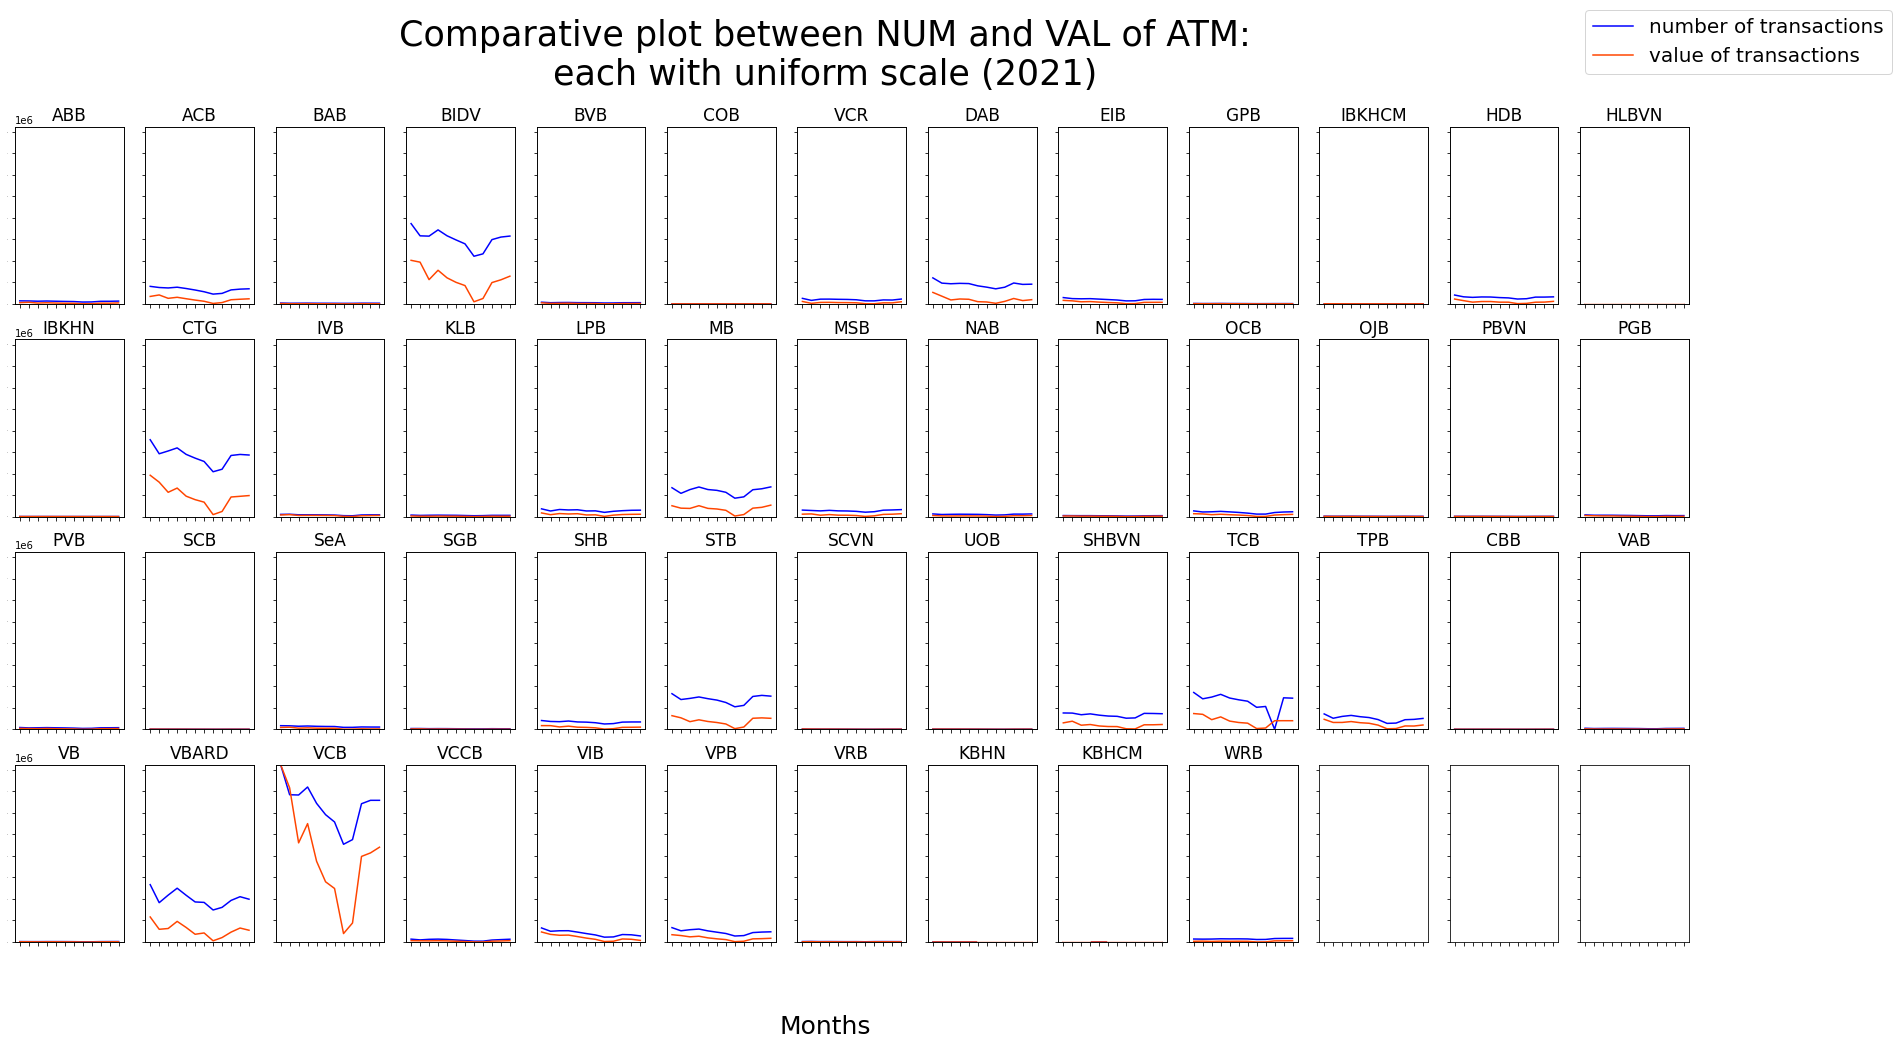

In [31]:
# of course, both num and val data have to be of the same year and service
if (num_atm_year != val_atm_year) or (num_atm_service != val_atm_service):
    exit("CANNOT EXECUTE, DATA ARE OF DIFFERENT YEARS AND/OR SERVICES!")

# plotting
comparative(df_atm_num, df_atm_val, val_atm_service, val_atm_year, 'S', 'uniform')

## **Overall trend of Service NUM as compared to VAL**
### (different scale for each)

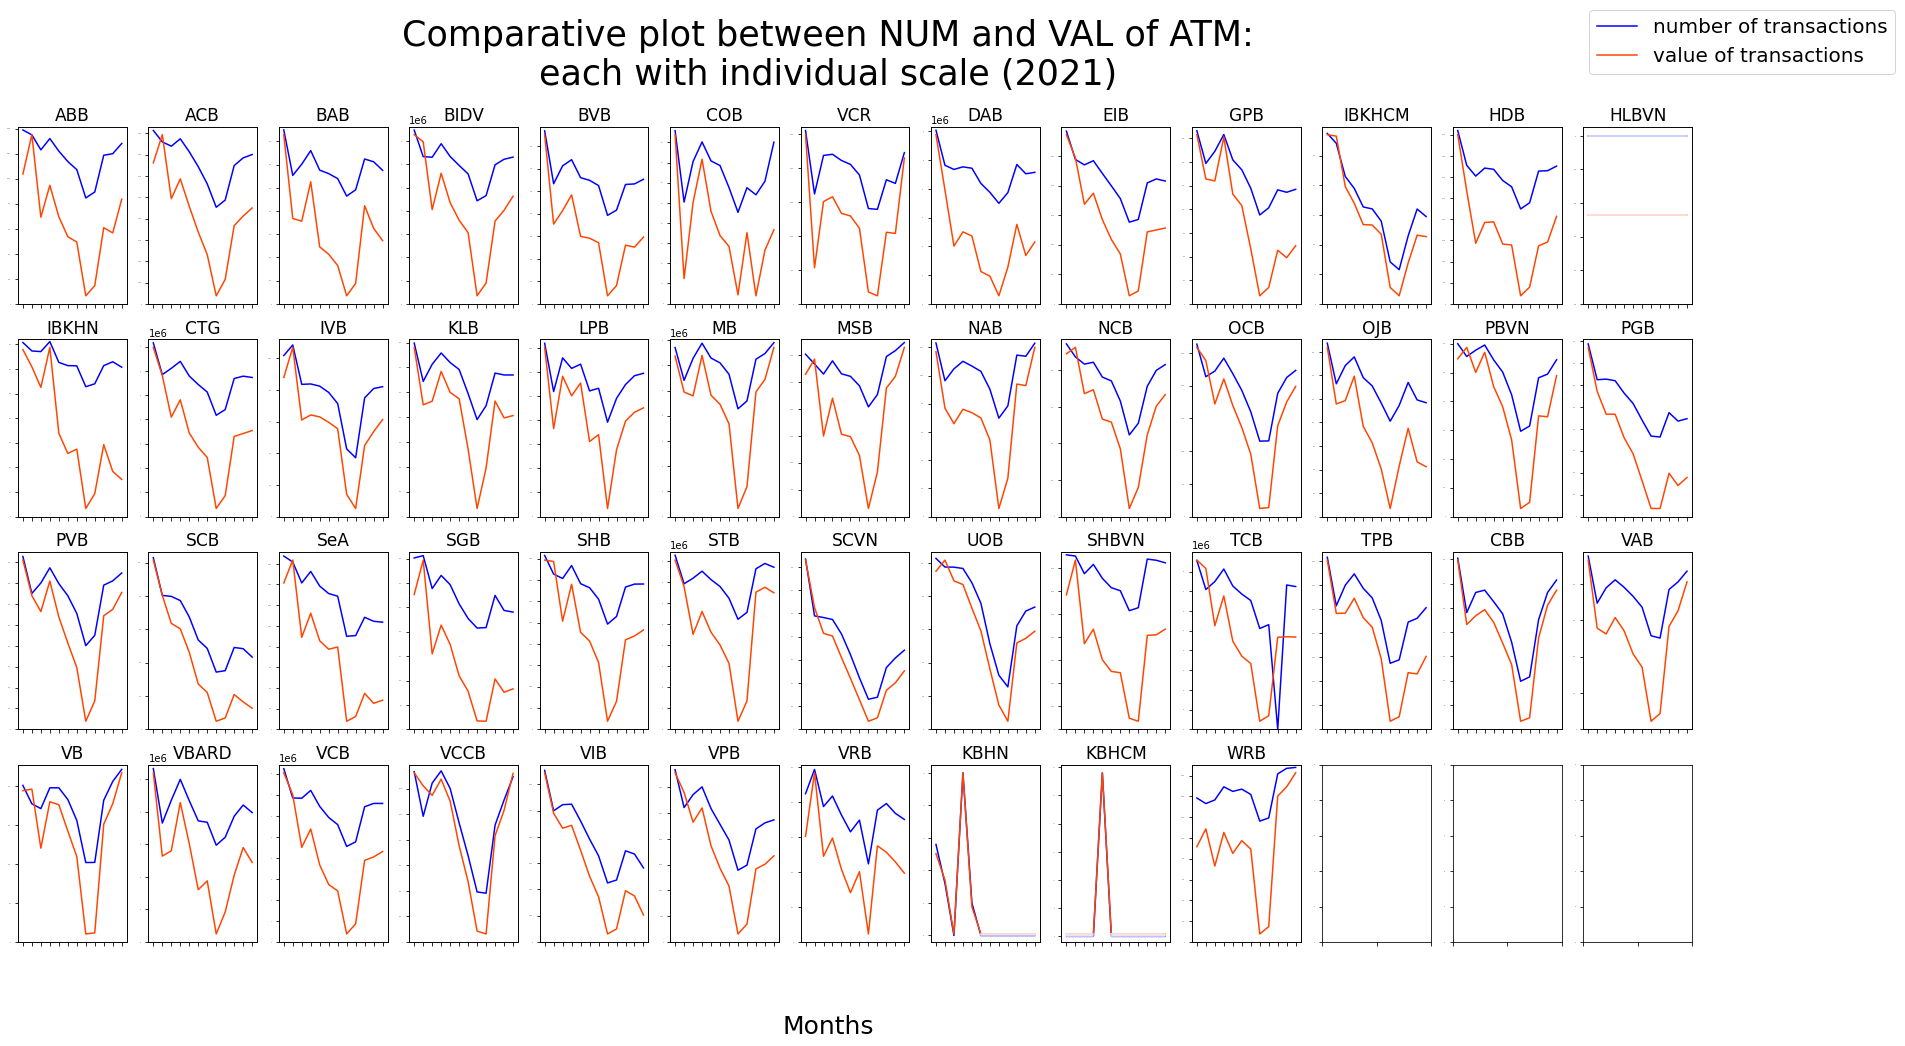

In [32]:
if (num_atm_year != val_atm_year) or (num_atm_service != val_atm_service):
    exit("CANNOT EXECUTE, DATA ARE OF DIFFERENT YEARS AND/OR SERVICES!")

# plotting
comparative(df_atm_num, df_atm_val, val_atm_service, val_atm_year, 'S', 'individual')

## **Transaction distribution by periodicity (monthly)**
### Number of transactions

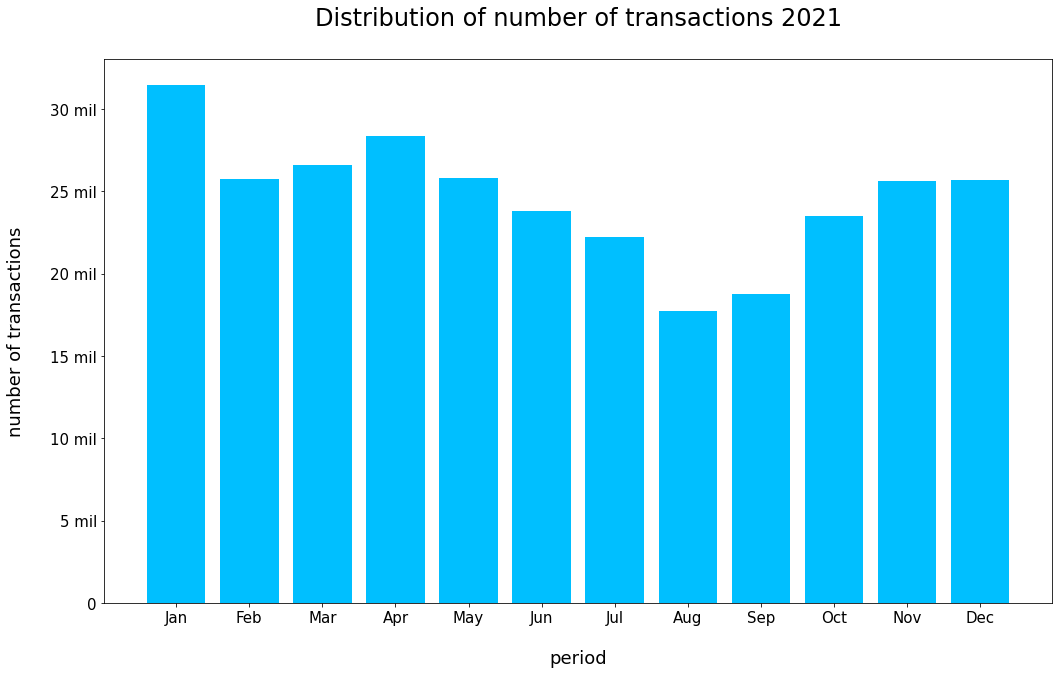

In [33]:
# number of transactions in period visualization
fig, ax = plt.subplots(figsize=(17,10))
period = df_atm_num.columns

ax.bar(list(period),[sum(df_atm_num.iloc[:,i]) for i in range(len(period))],color='deepskyblue')
ax.set_title("Distribution of number of transactions {}\n".format(num_atm_year), size=24)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='both', labelsize=15)
ax.set_xlabel("\nperiod", size=18)
ax.set_ylabel("number of transactions\n", size=18)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([millify(x) for x in ticks_loc])
fig.show()

### Value of transactions

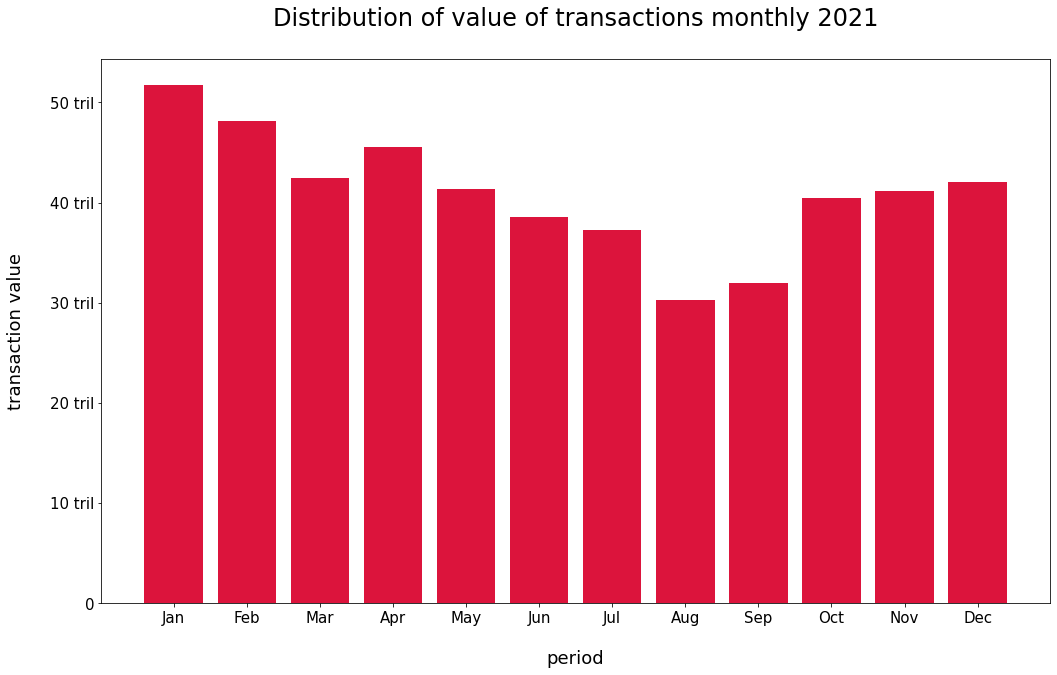

In [34]:
# visualization
fig, ax = plt.subplots(figsize=(17,10))
period = df_atm_val.columns

ax.bar(list(period),[sum(df_atm_val.iloc[:,i]) for i in range(len(period))],color='crimson')
ax.set_title("Distribution of value of transactions monthly {}\n".format(val_atm_year), size=24)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='both', labelsize=15)
ax.set_xlabel("\nperiod", size=18)
ax.set_ylabel("transaction value\n", size=18)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([millify(x) for x in ticks_loc])
fig.show()

_______________________________________
_______________________________________
# <u>Past and current data summary</u>
_______________________________________

## **Comparative VAL between previous and current year**

## Uniform scale

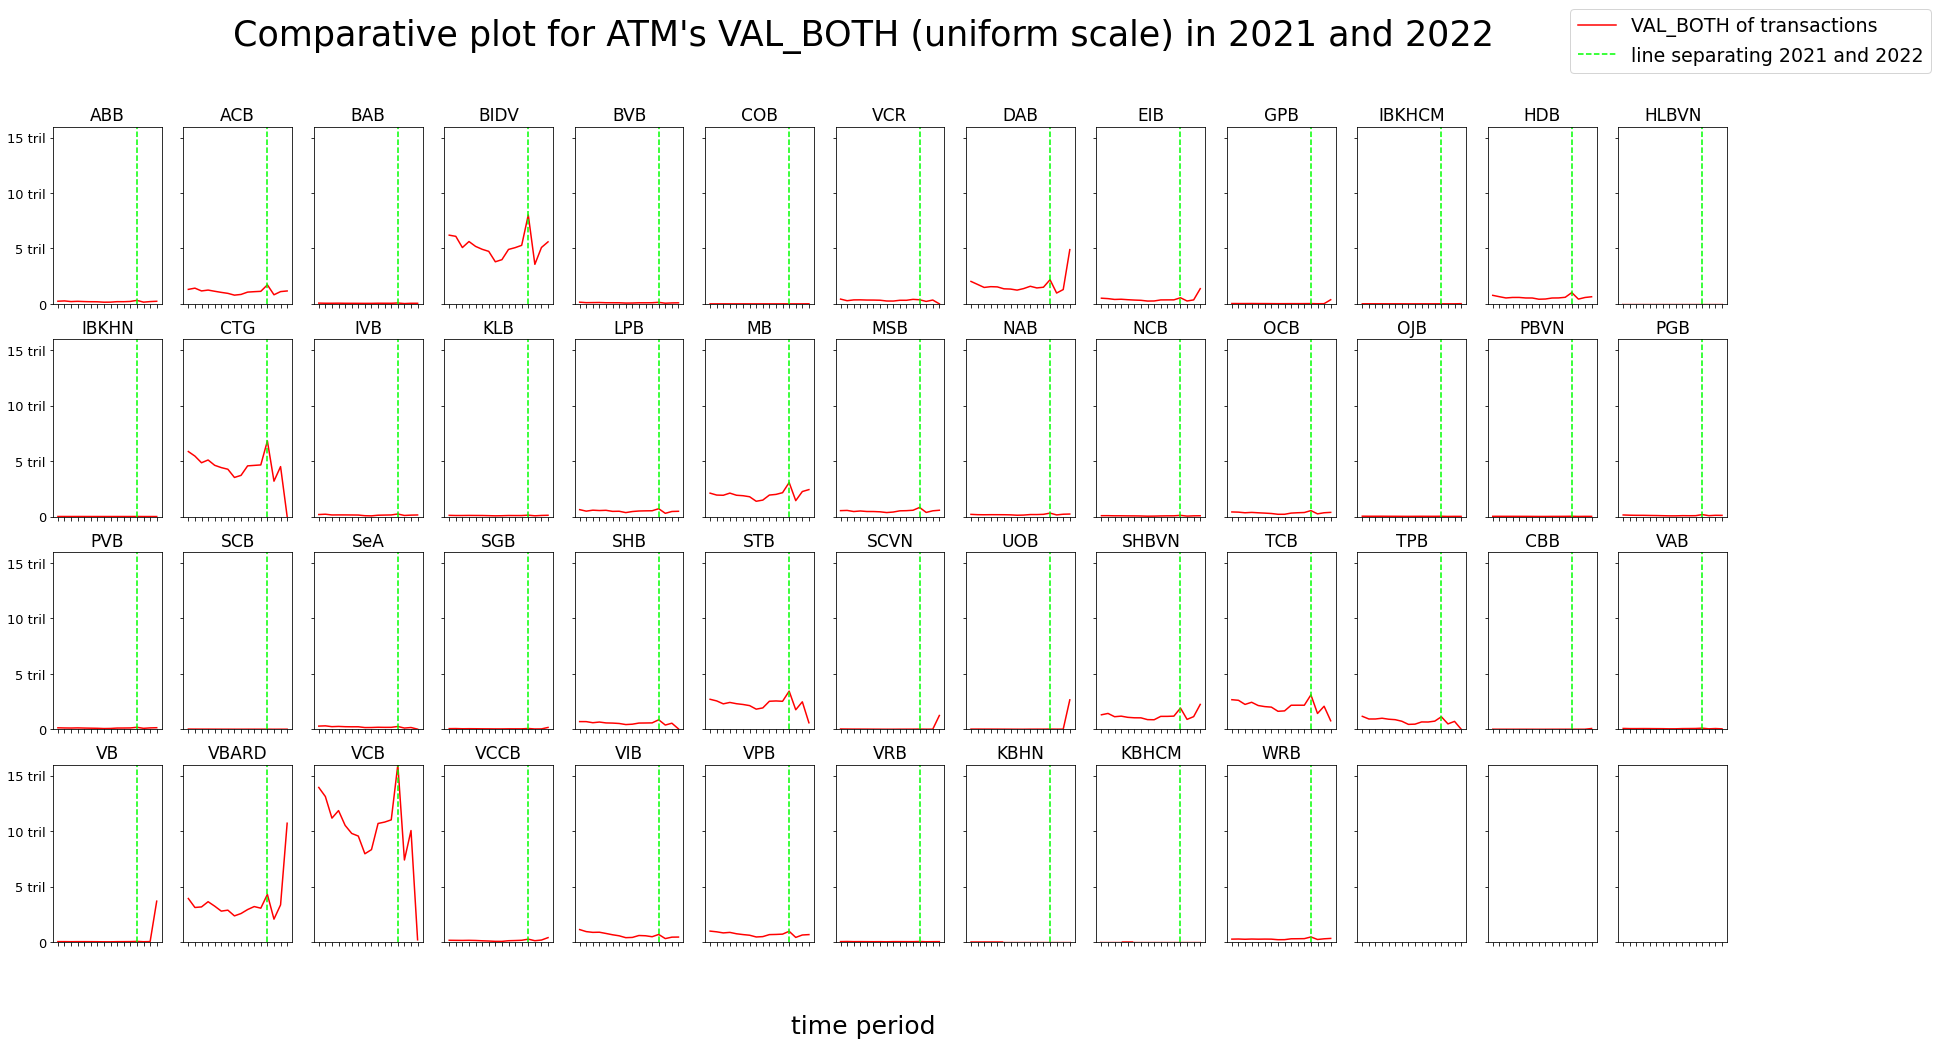

In [35]:
nv1_plot(df_val_both, val_both_service, val_both_year, 'VAL_BOTH', 'uniform')

## Individual scale

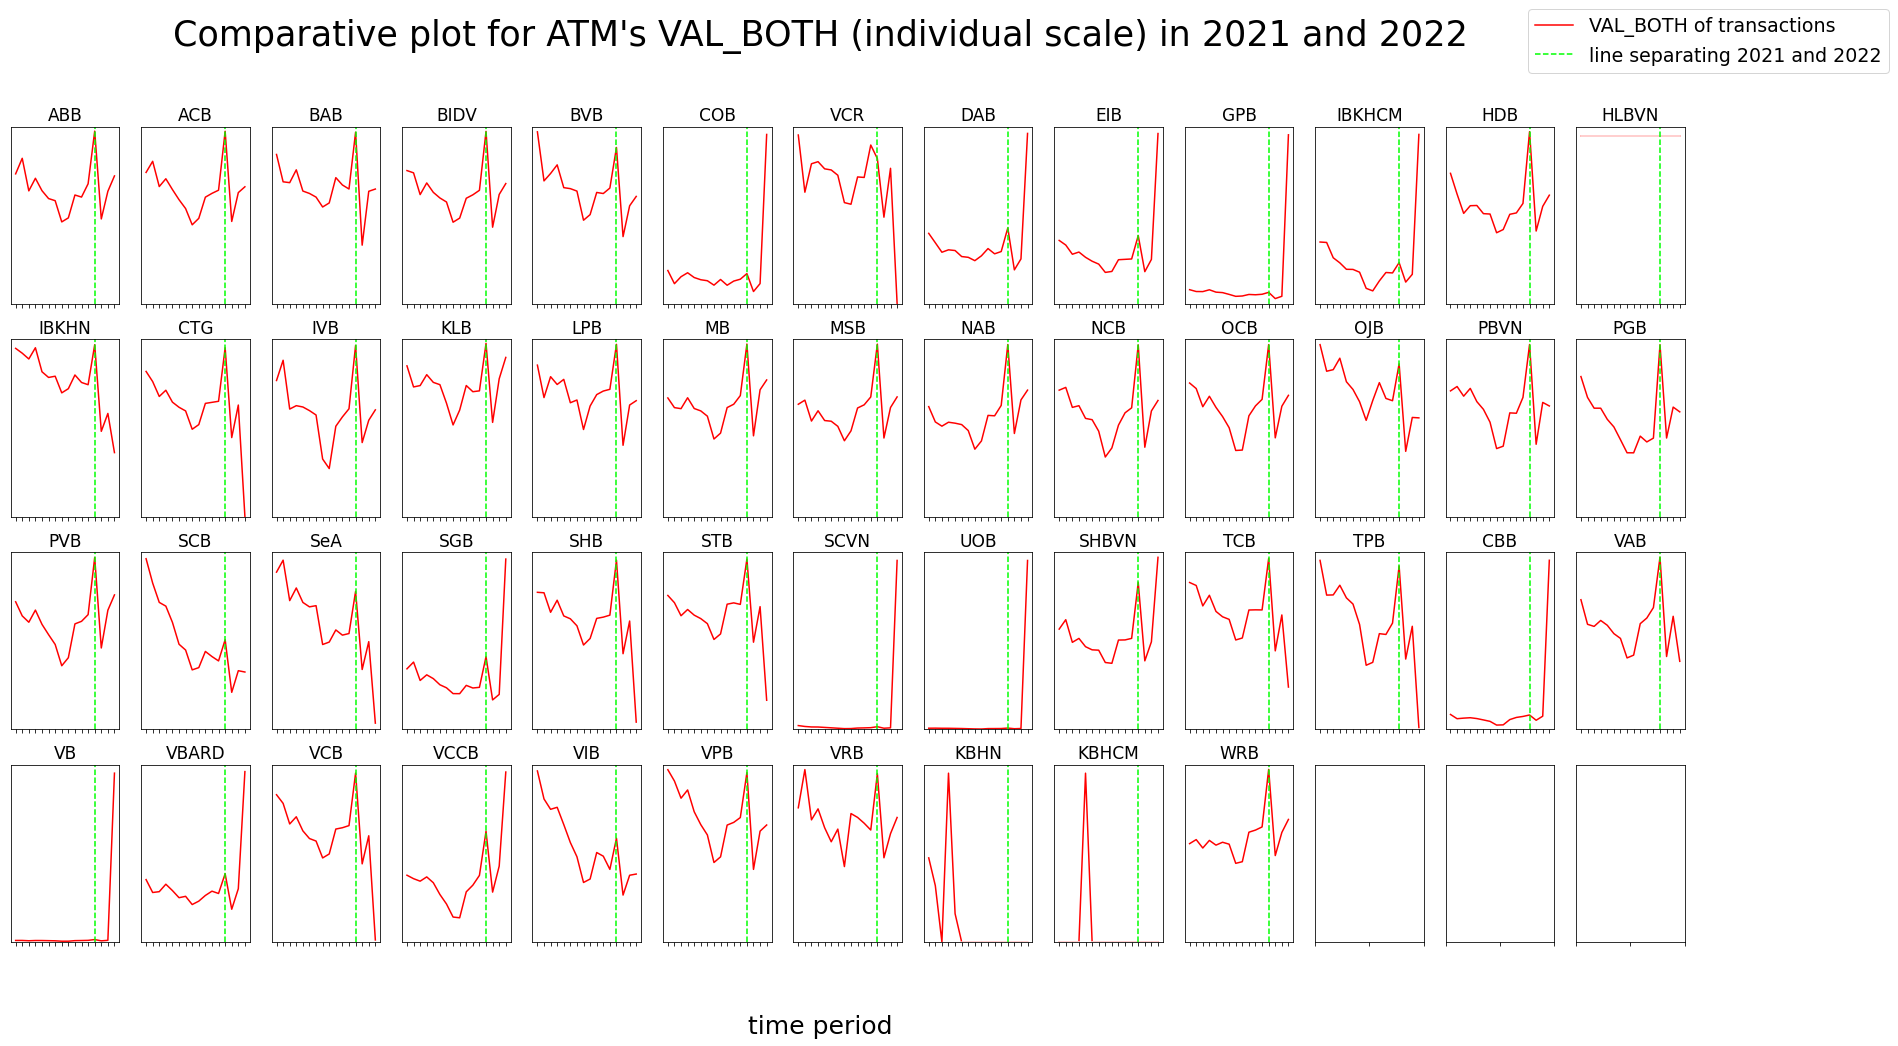

In [36]:
nv1_plot(df_val_both, val_both_service, val_both_year, 'VAL_BOTH', 'individual')

## **Comparative NUM and VAL between previous and current year**

## Uniform scale

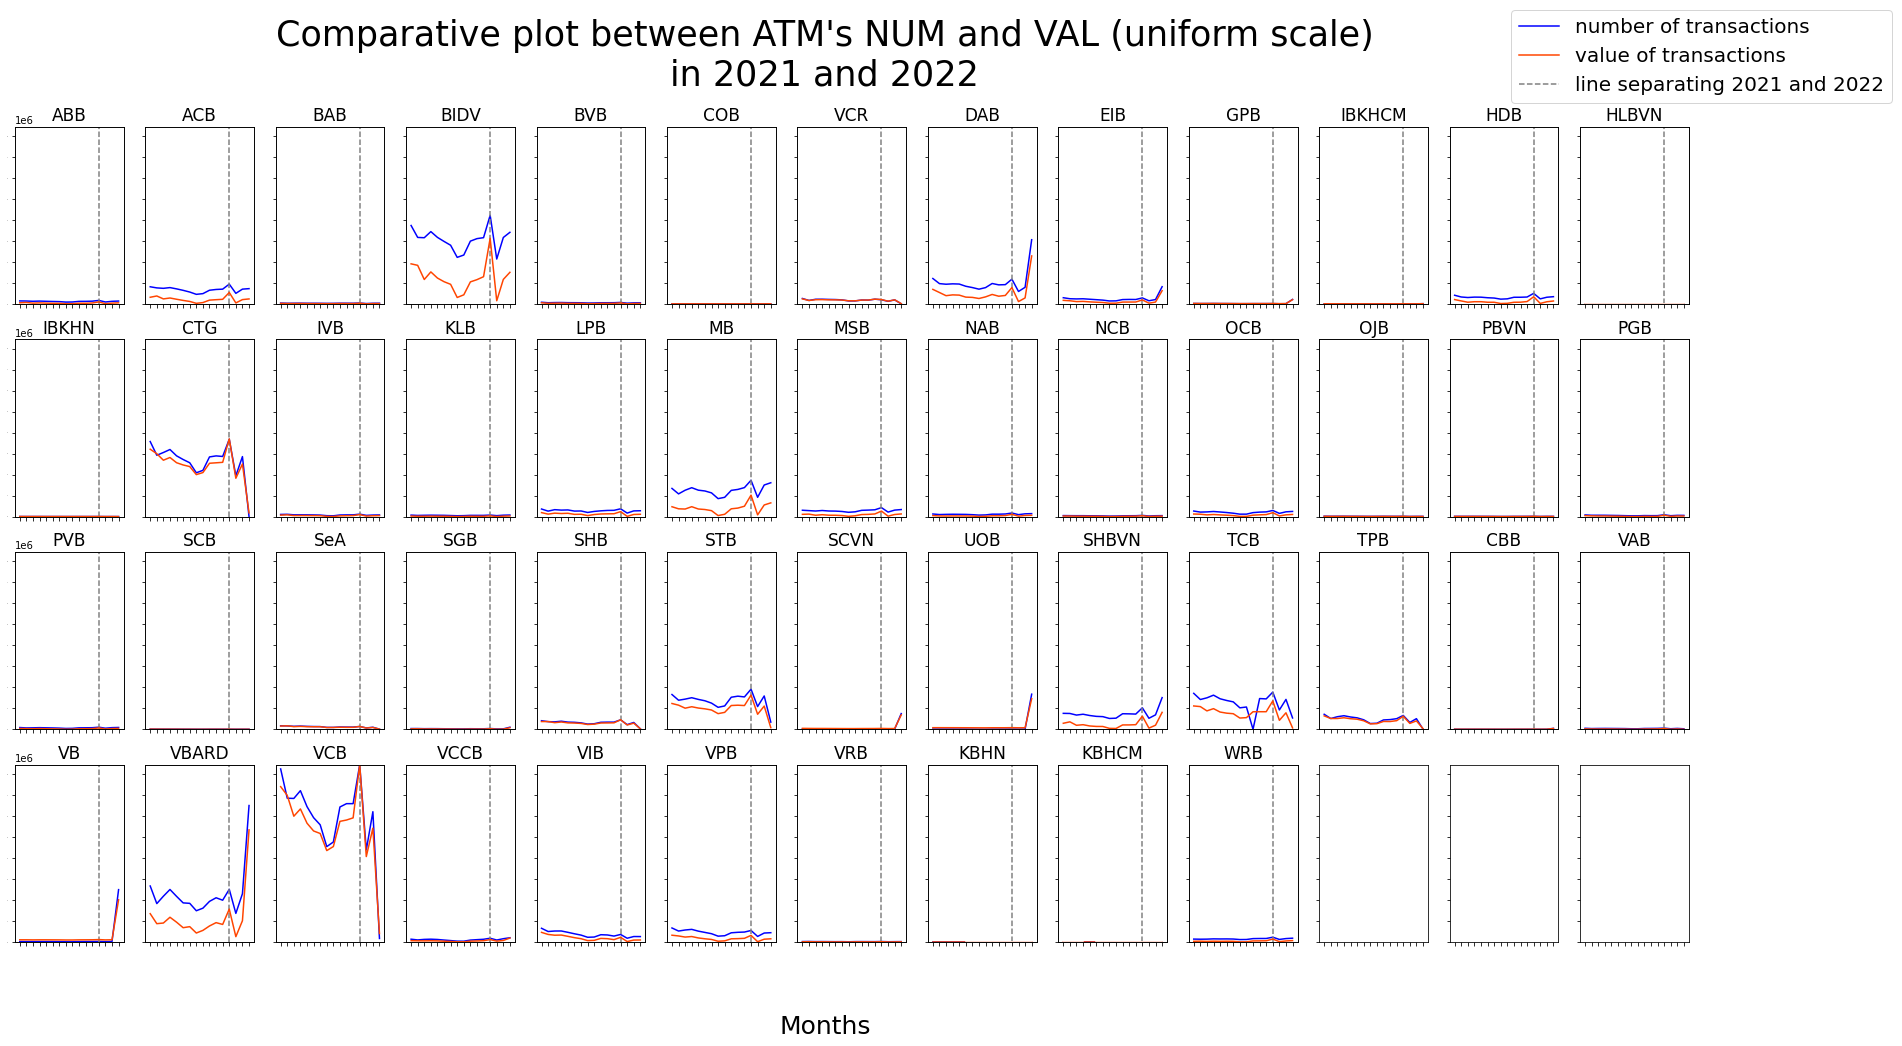

In [37]:
if (num_both_year != val_both_year) or (num_both_service != val_both_service):
    exit("CANNOT EXECUTE, DATA ARE OF DIFFERENT YEARS AND/OR SERVICES!")

comparative(df_num_both, df_val_both, val_both_service, val_both_year, 'BOTH', 'uniform')

## Individual scale

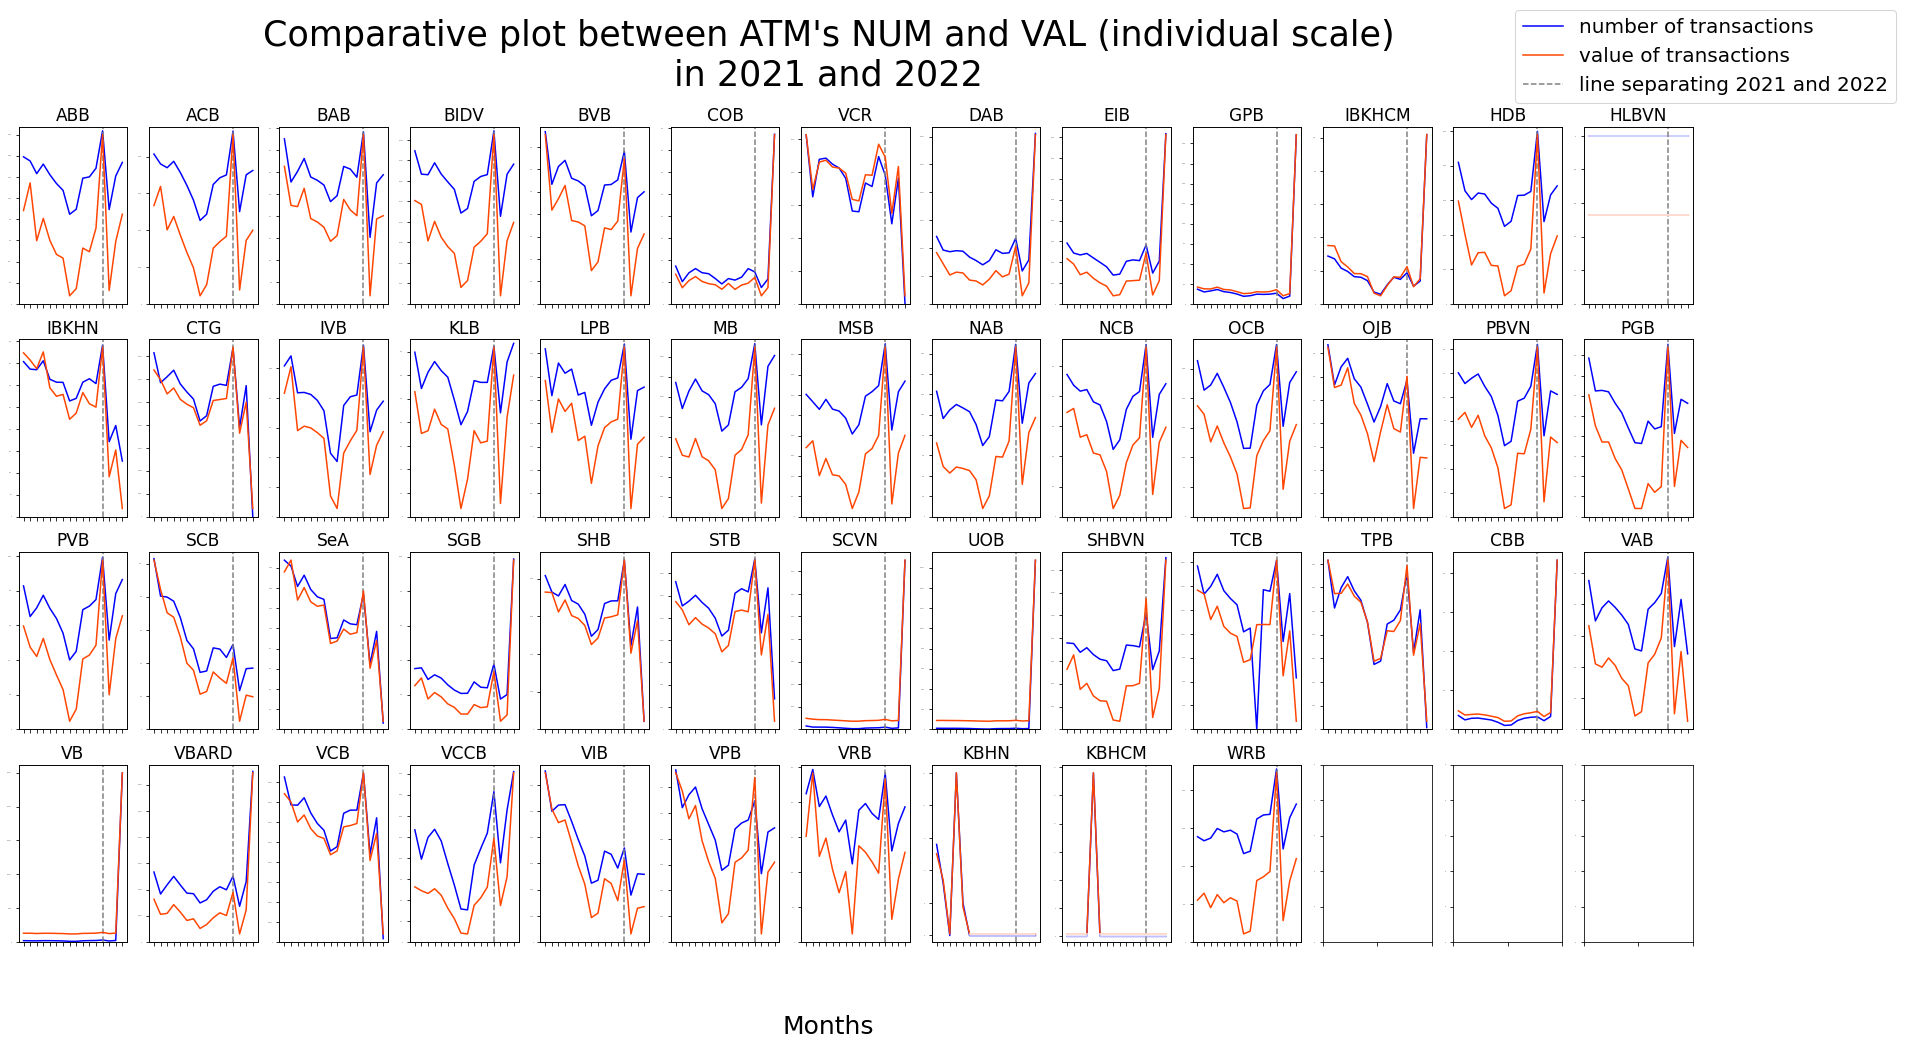

In [38]:
if (num_both_year != val_both_year) or (num_both_service != val_both_service):
    exit("CANNOT EXECUTE, DATA ARE OF DIFFERENT YEARS AND/OR SERVICES!")

comparative(df_num_both, df_val_both, val_both_service, val_both_year, 'BOTH', 'individual')

## **Annual summary**

	     +-----------------------------------------+
	     | Current (hence incomplete) year is 2022 |
	     +-----------------------------------------+


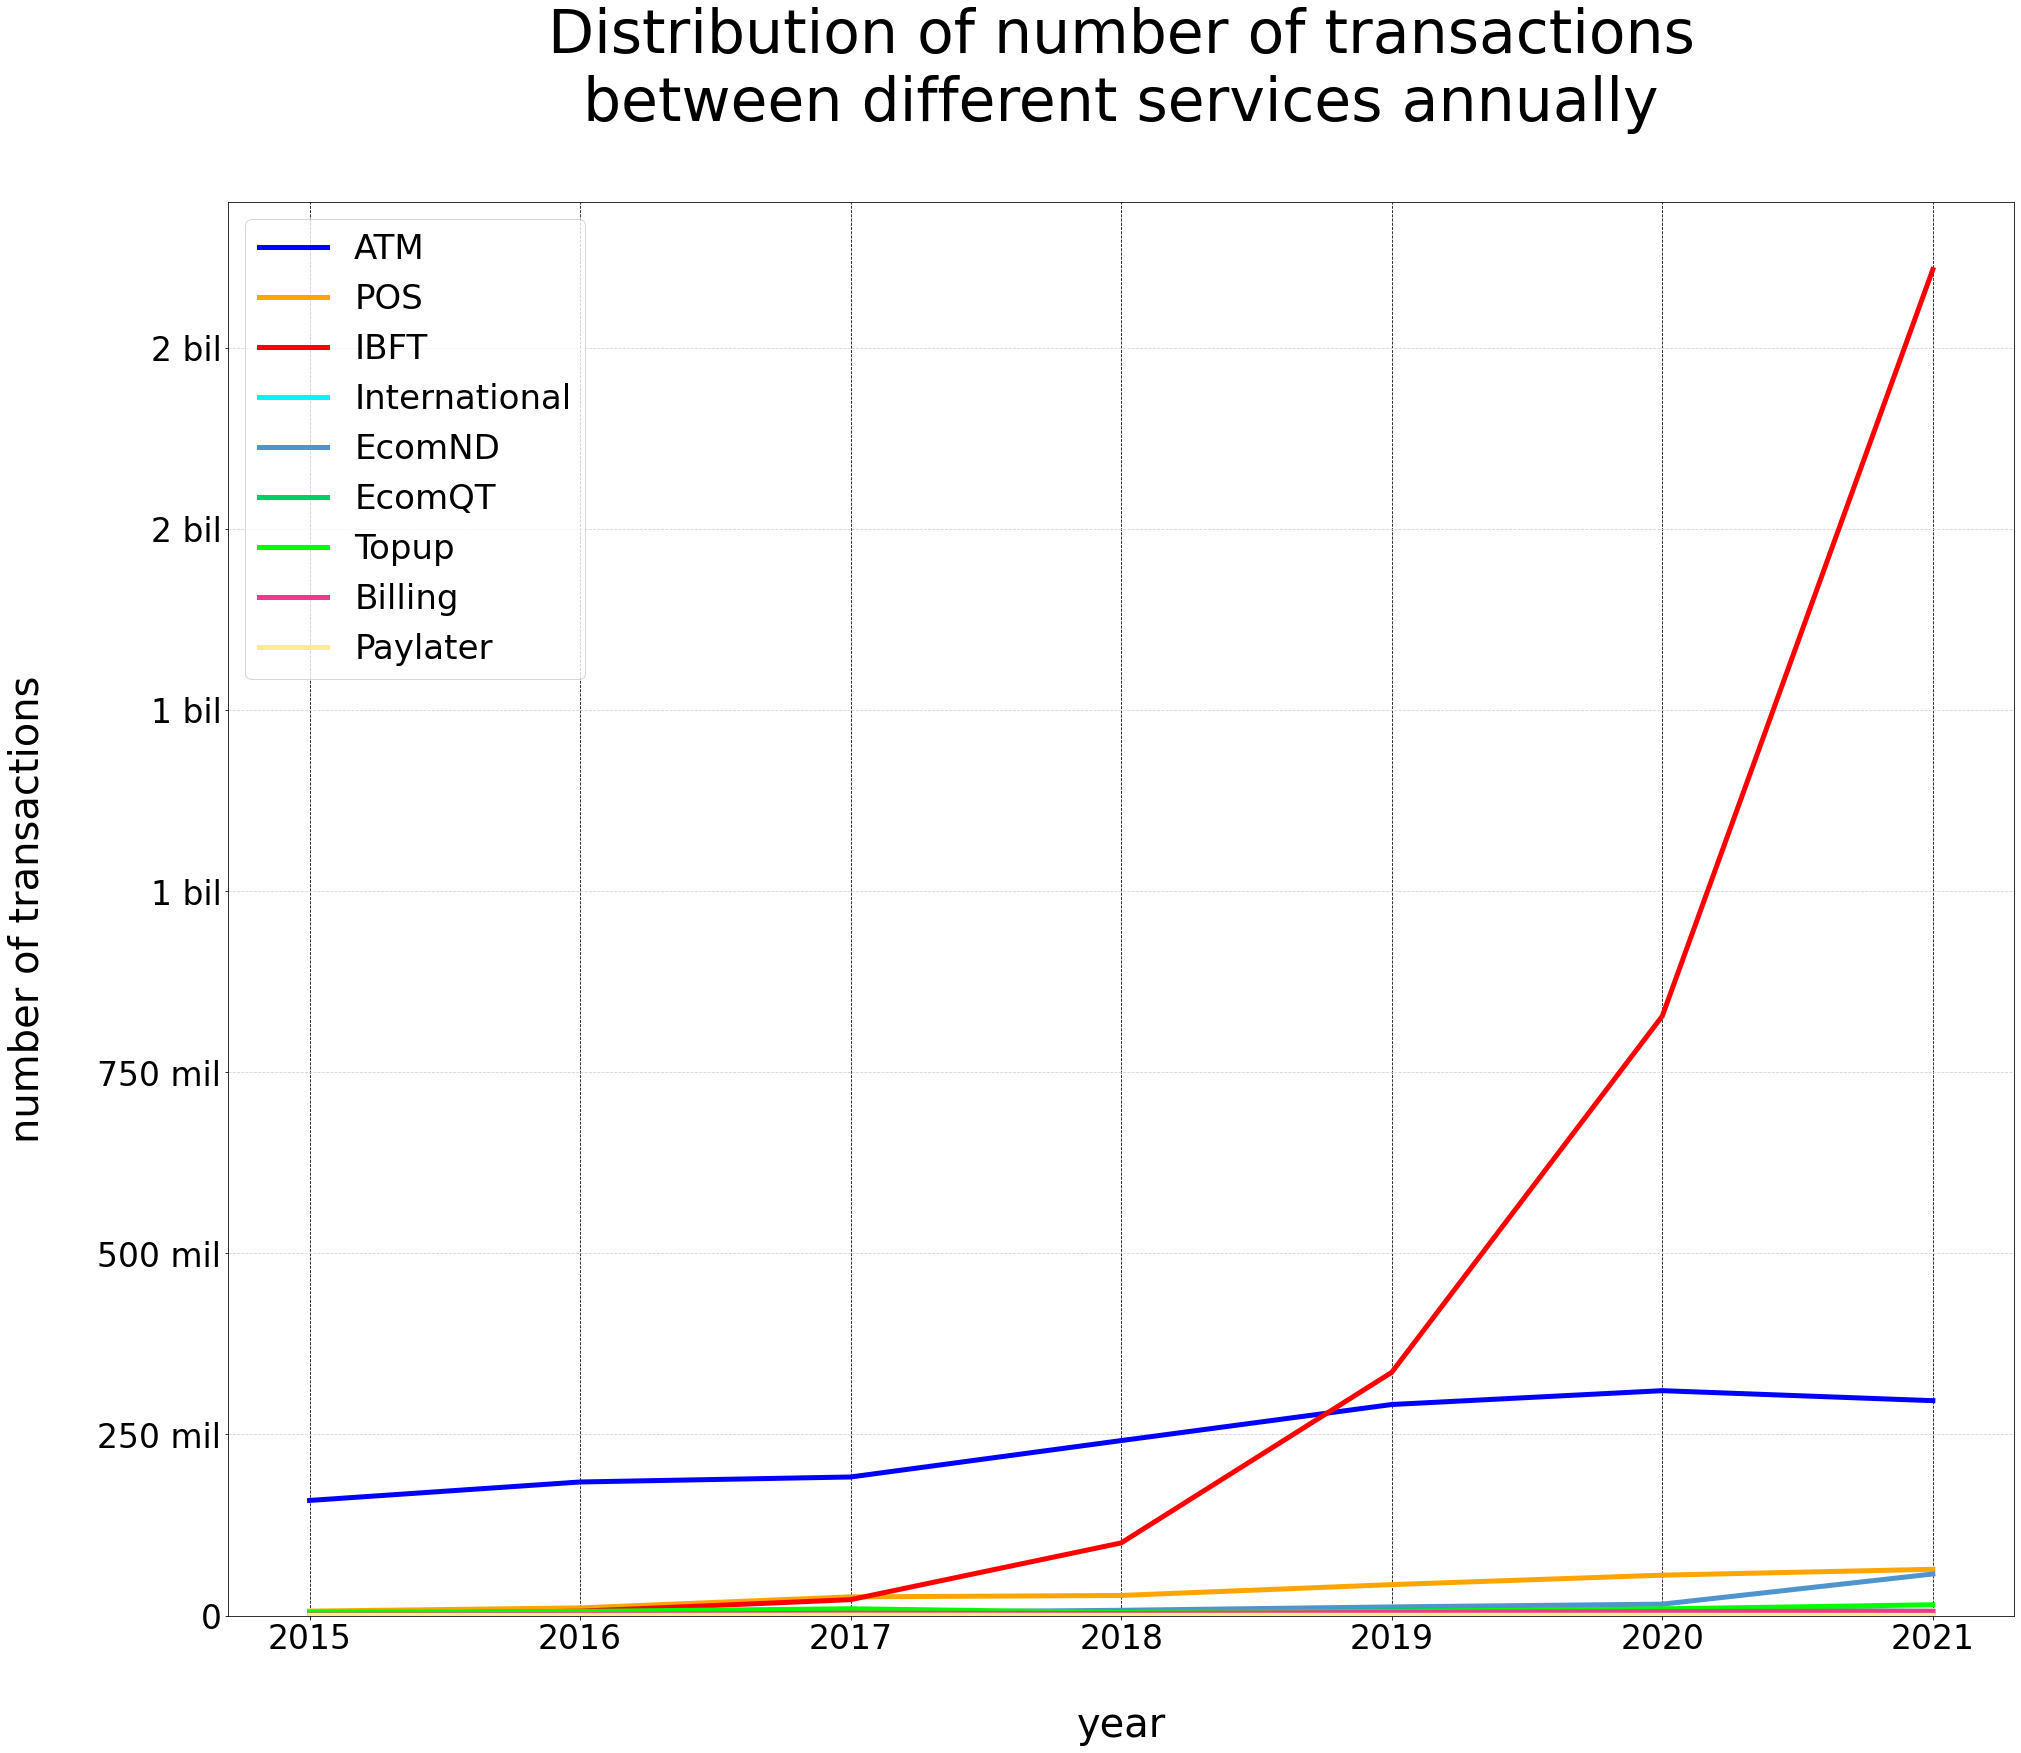

In [39]:
fig, ax = plt.subplots(figsize=(32,26))
colors=['blue', 'orange', 'red', '#00F5FF', '#4F94CD', '#00CD66',
        'lime', '#EE3A8C', '#FFEC8B', 'lightpink']
handles=[]
pattern = r'(\d+)_\((\w+)\)'

# not including current year
til = 0
for i in df_sum.columns:
    if re.findall(pattern, i):
        print("\t     +-----------------------------------------+")
        print("\t     | Current (hence incomplete) year is",re.findall(pattern, i)[0][0],"|")
        print("\t     +-----------------------------------------+")
        break
    til += 1
df_sum_nocurr = df_sum.iloc[:, :til]

# plotting and coloring
x = df_sum_nocurr.columns
for i in range(len(df_sum_nocurr)):
    if i <= len(colors):
        ax.plot(x, df_sum_nocurr.iloc[i], linewidth=5, color=colors[i])
    else:
        ax.plot(x, df_sum_nocurr.iloc[i], linewidth=5)
        done = False
        while not done:
            r = random.randint(0,255)
            g = random.randint(0,255)
            b = random.randint(0,255)
            rgb = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
            if rgb[0] not in colors:
                colors.append(rgb[0])
                done = True
    handles.append(Line2D([0],[0], label=df_sum_nocurr.index[i], color=colors[i], linewidth=5))
ax.set_ylim(bottom=0)

# titles, labels and ticks
ax.set_title(
    "Distribution of number of transactions\nbetween different services annually\n",size=60)
ax.tick_params(axis='y', which='major', labelsize=33)
ax.tick_params(axis='x', which='both', labelsize=33)
ax.set_xlabel("\nyear", size=40)
ax.set_ylabel("number of transactions\n", size=40)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([millify(x) for x in ticks_loc])
ax.grid(axis='x', linestyle='--', color='black')
ax.grid(axis='y', linestyle='--', color='lightgrey')

# graph's legend
plt.legend(handles=handles, prop={'size': 34})
fig.show()

_______________________________________
_______________________________________
# <u>ML models for forecasting future transactions</u>
_______________________________________

**Available periods for current year**

In [40]:
if start_pred not in list(df_2prev.index) or start_pred > furthest_av:
    exit("Invalid starting point for prediction (start_pred). Select start_pred that is in csv file.")

# prediction period
period_pred = len(df_2prev.loc[start_pred:])

# index of furthest available point in dataset
f_index = df_2prev.index.get_loc(furthest_av) + 1

**Performance metrics helper functions**

In [41]:
# rmse performance metrics
def rmse(a,b):
    return np.sqrt(np.mean(a-b)**2)

**Plot beautifying helper function**

In [78]:
def beautify(df, ax, column, model, *arima_diff):
    latest_year = int(df.index[-1].year)
    earliest_year = int(df.index[0].year)

    # ticks
    pattern = r'(\d{4,4})-(04|07|12)'
    x = [i for i in range(len(df.index))]
    for i in x:
        xtype = i
        if model=='SMA':
            xtype = df.index[i]
        if re.findall('-12-', str(list(df.index)[i])):
            ax.axvline(x=xtype, color='lime', linestyle='--', linewidth=2)
        elif re.findall(pattern, str(list(df.index)[i])):
            ax.axvline(x=xtype, color='lightgrey', linestyle='--', linewidth=1)

    if model != 'SMA':
        ax.set_xticks(x, ["{}".format(df.index[i].strftime("%b-%Y"))
            if re.findall(pattern, str(list(df.index)[i])) else '' for i in x])
    ax.tick_params(axis="x", direction="in", labelsize=23, labelrotation=40, color="navy")
    ax.tick_params(axis="y", labelsize=25)
    
    # Labels
    ax.set_xlabel("\n{} (from {} to {})".format(
        periodicity, earliest_year, latest_year), fontsize=30)
    ax.set_ylabel("{}\n".format(type_2prev), fontsize=30)
    if ((model == 'ARIMA') and (arima_diff[0] == 0)) or (model != 'ARIMA'):
        ax.set_ylim(bottom=0)
    
    # title
    if model == 'ARIMA':
        ax.set_title("{} model forecasting {}-diff {}'s {} from {} in {}\n".format(
            model, arima_diff[0], column, type_2prev, service_2prev, latest_year), fontsize=50)
    elif model == 'SMA':
        ax.set_title("{} visualizing trend of {}'s {} from {} in {}\n".format(
            model, column, type_2prev, service_2prev, latest_year), fontsize=50)
    else:
        ax.set_title("{} model forecasting {}'s {} from {} in {}\n".format(
            model, column, type_2prev, service_2prev, latest_year), fontsize=50)
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels([millify(x) for x in ticks_loc])

## **1. LSTM** (Univariate)

In [44]:
# model function
def LSTM_univariate(df, column, window_size):
    training_len = len(df) - period_pred

    # Checking only the feature value of df
    df_feature = df.filter([column])
    # Convert df_feature into NumPy array
    np_df_feature = df_feature.values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_df_feature = scaler.fit_transform(np_df_feature)

    train  = scaled_df_feature[:training_len]
    x_train = []
    y_train = []

    for i in range (window_size, training_len):
        x_train.append(train[i-window_size:i,0])
        y_train.append(train[i,0])

    # convert x_train,y_train to numpy array
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # reshape the data
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

    # build the LSTM models 
    model = Sequential()
    model.add(LSTM(120, return_sequences = True, input_shape = (window_size, 1)))
    model.add(LSTM(100, return_sequences = False))
    model.add(Dense(period_pred))
    model.add(Dense(1))

    # Compile the models
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size = 256, epochs = 100, verbose=0)

    # Create the testing dataset
    # Create a new array containing scaled values from index
    test = scaled_df_feature[training_len-window_size:f_index]
    test_all = scaled_df_feature[training_len-window_size:]

    # Create the datasets x_test and y_test
    x_test = []
    x_test_all = []
    y_test = np_df_feature[training_len:f_index, :]
    for i in range(window_size, len(test)):
        x_test.append(test[i-window_size:i, 0])

    for i in range(window_size, len(test_all)):
        x_test_all.append(test_all[i-window_size:i, 0])

    # transform x_test to an numpy array
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_test_all = np.array(x_test_all)
    x_test_all = x_test_all.reshape(x_test_all.shape[0], x_test_all.shape[1], 1)

    pred = model.predict(x_test)
    pred = scaler.inverse_transform(pred)
    pred_all = model.predict(x_test_all)
    pred_all = scaler.inverse_transform(pred_all)

    # Plotting
    training = np_df_feature[:training_len]
    testing = np_df_feature[training_len:f_index]
    train_pred = np.concatenate((training, pred_all), axis=None)

    print(len(pred_all))
    
    fig, ax = plt.subplots(figsize = (32,18))
    ax.plot(train_pred, label='predict', color = 'b', linewidth=4)
    ax.plot(np_df_feature, label='true', color = 'r', linewidth=4)
    ax.plot(training, label='train', color = 'k', linewidth=4)

    beautify(df, ax, column, "LSTM")
    plt.legend(prop={'size':30})

    # performance metrics
    rmse_LSTM = rmse(testing, pred)
    print("\n")
    print("+----------------------+")
    print("| Performance metrics: |")
    print("+----------------------+")
    print("rmse:", rmse_LSTM)
    print("Last value error:", int(pred[-1]-testing[-1]))

    # Trend evaluation
    if pred[-1] < 0.95*training[-1]:
        prediction = "up"
        print("predicted downtrend")
    elif pred[-1] > 1.05*training[-1]:
        print("predicted uptrend")
        prediction = "down"
    else:
        print("predicted sideway")
        prediction = "side"

    if testing[-1] < 0.95*training[-1]:
        actual = "up"
        print("actual downtrend")
    elif testing[-1] > 1.05*training[-1]:
        print("actual uptrend")
        actual = "down"
    else:
        print("actual sideway")
        actual = "side"
    if actual == prediction:
        print("Correct trend prediction") 
    else: 
        print("False trend prediction")

### *Model parameter*

```
LSTM_univariate(
    dataframe,
    column='bank name',
    window_size=n
)
```
Second parameter (only parameter most likely required to change) is ***'bank name'*** (in single quotation mark). *'bank name'* is the abbrieviated bank name form (i.e. 'ABB', 'BIDV', etc.).

2022-07-09 18:48:05.318373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 18:48:05.318734: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1/1 [==============================] - 0s 43ms/step
11


+----------------------+
| Performance metrics: |
+----------------------+
rmse: 350417.75
Last value error: -166498
predicted downtrend
actual downtrend
Correct trend prediction


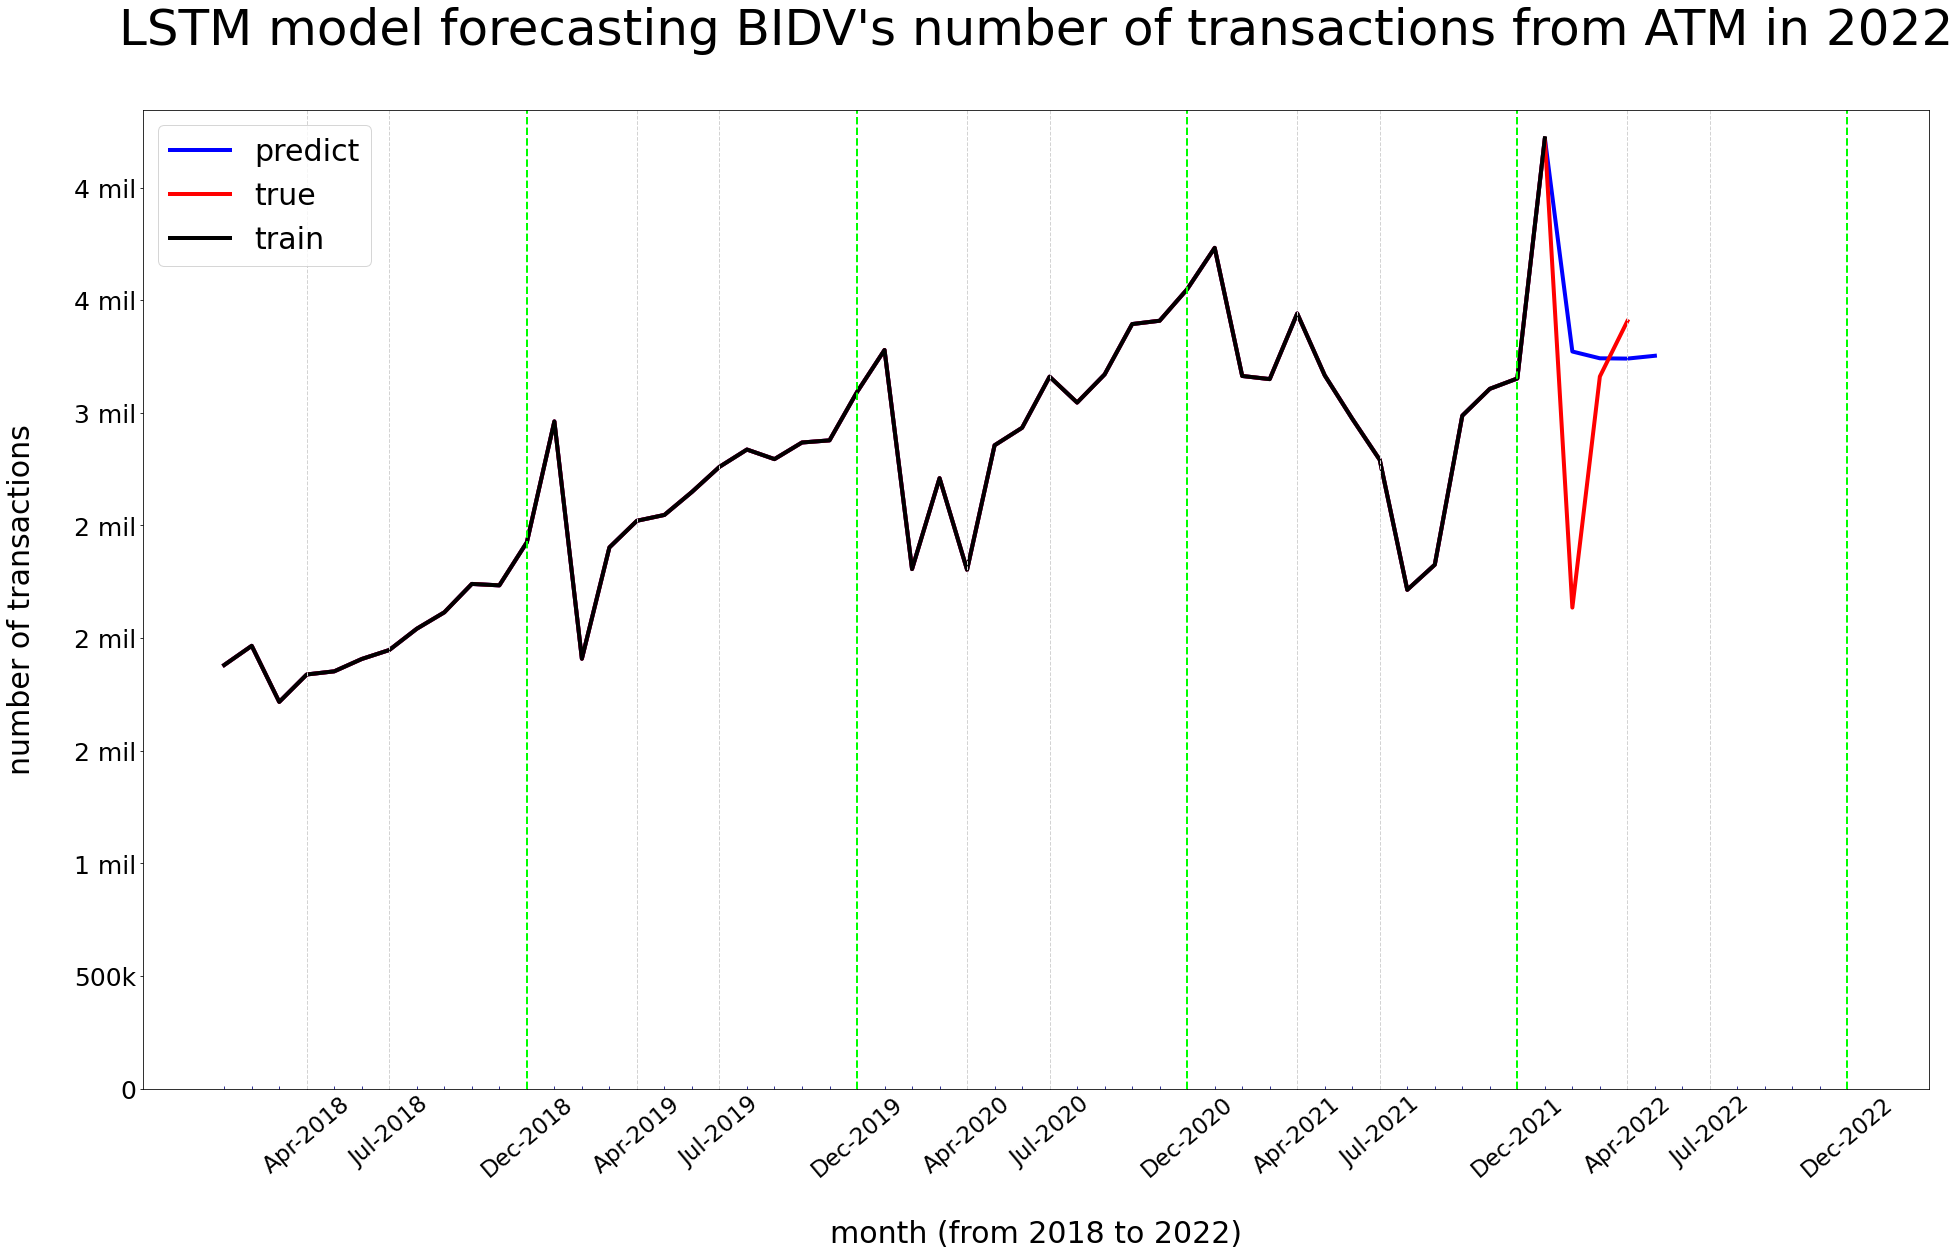

In [45]:
LSTM_univariate(
    df_2prev,
    column=bank_name,
    window_size=30
)

## **2. AR and ARIMA**

### 2.0. AR - Autoregression (not particularly useful)

In [46]:
def AR_mech(df, column, lags):
    testing_len = period_pred
    x = df[column].values
    train = x[:len(x)-testing_len]
    test = x[len(x)-testing_len:f_index]

    # Object Data type is accept all data-type
    Data_type = object 
    np.array(train, dtype=Data_type)

    # Build AR model
    model = AutoReg(train, lags=lags).fit()

    # Making Predictions
    pred = model.predict(start=len(train), end=f_index-1, dynamic=False)
    future_pred = model.predict(start=len(train), end=len(x)-1, dynamic=False)

    # Plotting
    train_pred = train 
    train_pred = np.concatenate((train_pred, future_pred), axis=None)
    fig, ax = plt.subplots(figsize = (32,18))
    ax.plot(train_pred, color='b', label='predict', linewidth=4)
    ax.plot(x, color='r', label='real', linewidth=4)
    ax.plot(train, label='train', color='k', linewidth=4)

    beautify(df, ax, column, "Autoregression")
    fig.legend(loc=(0.13,0.75), prop={'size':30})
    plt.show()

    # rmse
    print("+----------------------+")
    print("| Performance metrics: |")
    print("+----------------------+")
    print("rmse:", round(rmse(pred,test),0), "\n")

### 2.1. Optimal lag

In [47]:
from statsmodels.tsa.ar_model import ar_select_order

def optimalag(df, bank, period):
    if period != -1:
        try:
            mod = ar_select_order(list(df[bank]), maxlag=24, seasonal=True, period=period)
        except:
            print("Not enough data to pick optimal lag.")
            mod = [6,5,4,3,2,1]
    else:
        try:
            mod = ar_select_order(list(df[bank]), maxlag=24, glob=True)
        except:
            print("Not enough data to pick optimal lag.")
            mod = [6,5,4,3,2,1]
    return mod

mod = optimalag(df_2prev, bank_name, time_per)

Not enough data to pick optimal lag.


#### *Running AR model*

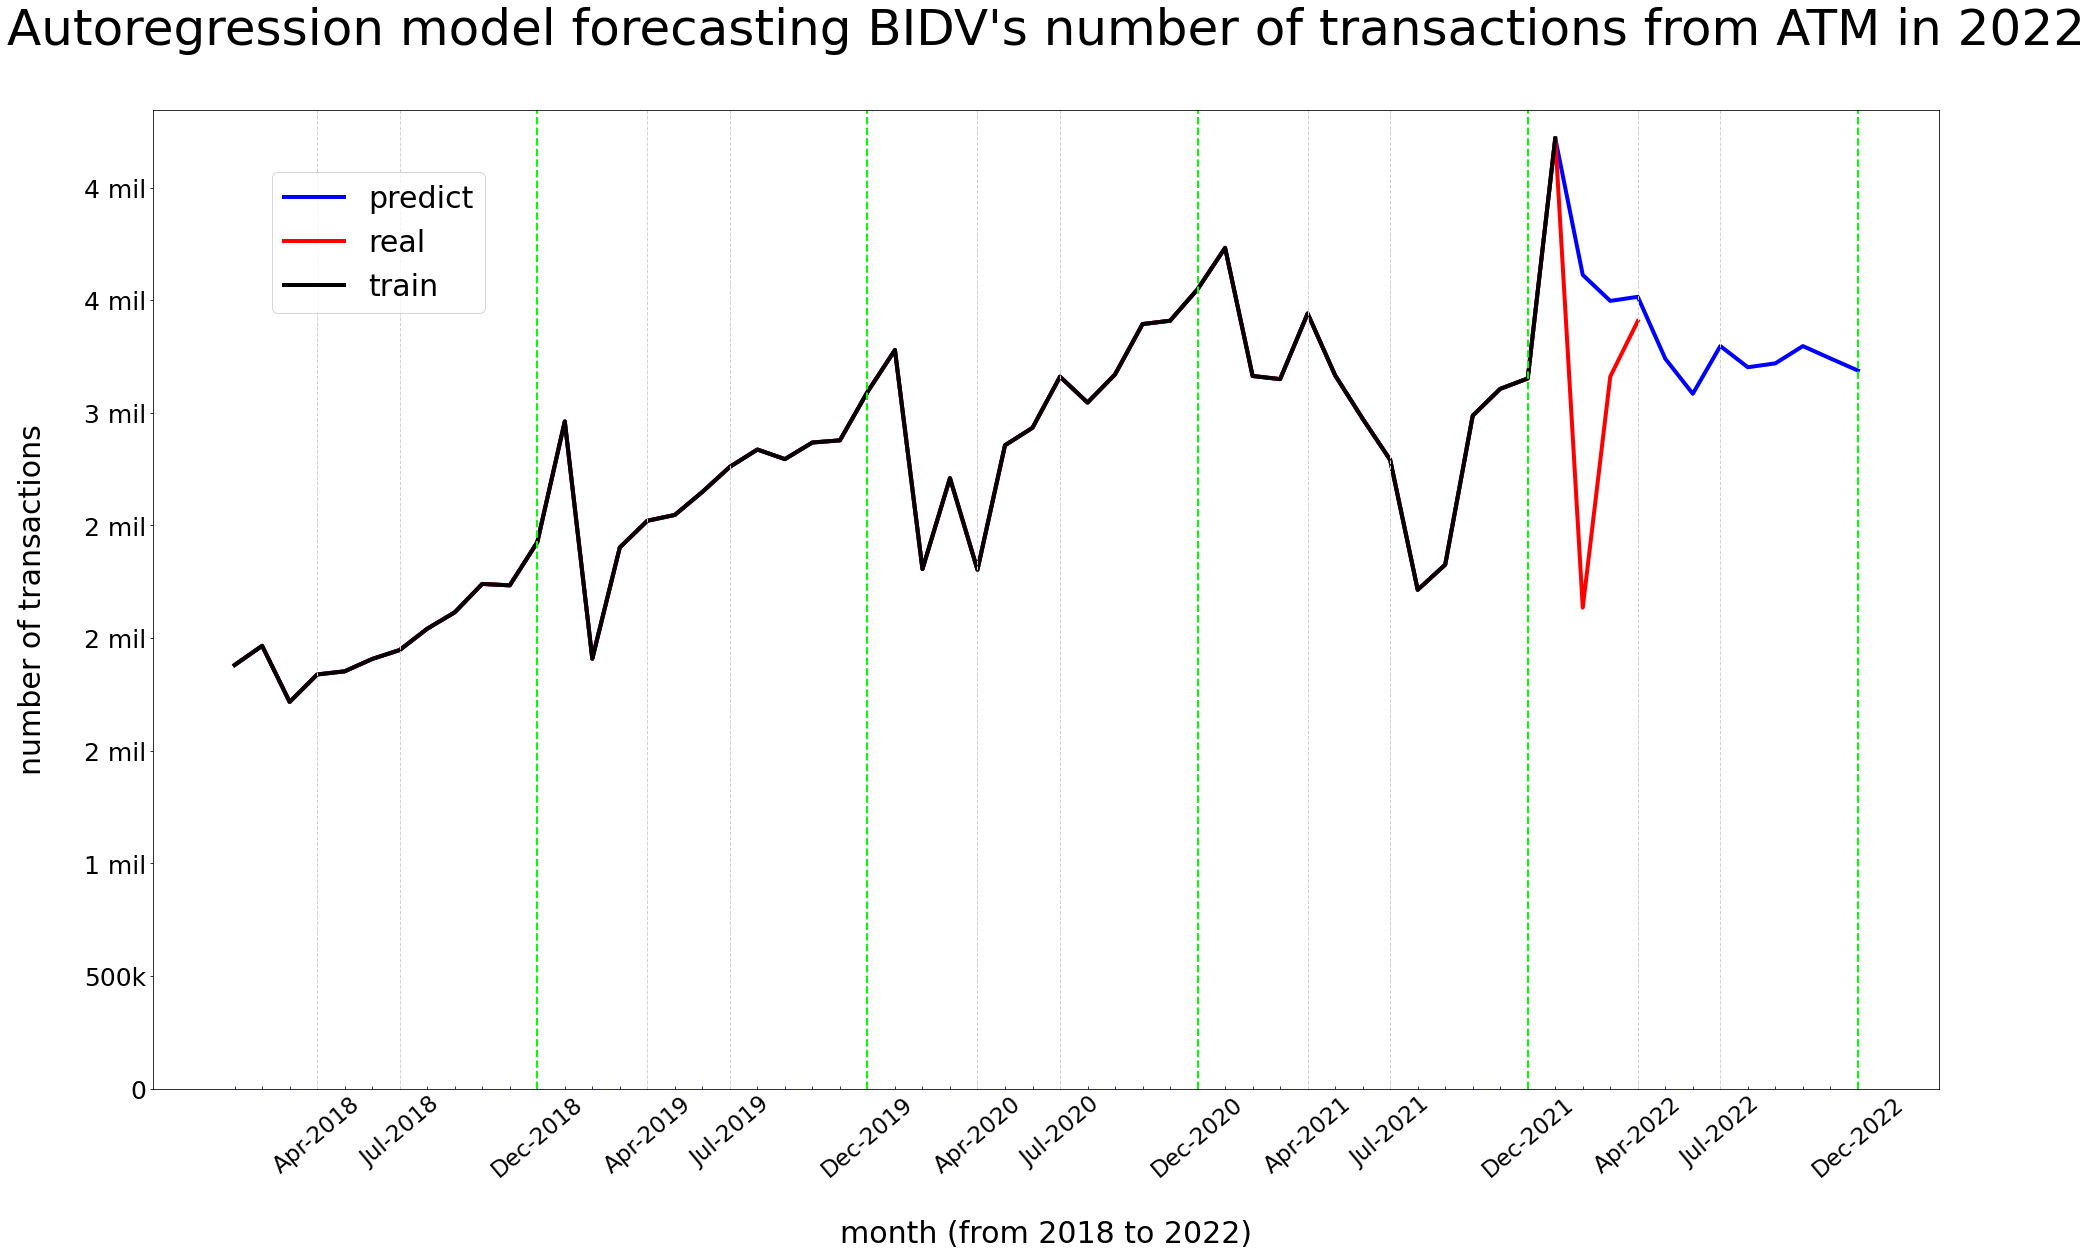

+----------------------+
| Performance metrics: |
+----------------------+
rmse: 640140.0 



In [48]:
def AR(df, column):
    lags = mod
    for i in lags:
        try:
            AR_mech(df, column, i)
            break
        except:
            print("Lag = {} is not possible due to insufficent data!".format(i))

AR(df_2prev, bank_name)

#### **ADF stationary check**

In [49]:
from statsmodels.tsa.stattools import adfuller

# checking for stationarity and return bool
def adf_stationary_check(X, alpha, diff):
    if not diff:
        X_diff = X.fillna(0)
    else:
        X_diff = X.diff().fillna(0)
    result = adfuller(X_diff)
    return alpha > result[1]

# getting the stationary series
def adf_stationary(X, alpha):
    diff_num = 0
    diff = 0
    X_d = X.fillna(0)
    while (not adf_stationary_check(X_d, alpha, diff)) and (diff_num <= 6):
        X_d = X_d.diff().fillna(0)
        diff_num += 1
        diff = 1
    if diff_num <= 6:
        result = adfuller(X_d)
        print('1. ADF Statistic: %f' % result[0])
        print('2. p-value: %f' % result[1])
        print("3. Number of lags:",result[2])
        print('4. Number of observations used:',result[3])
        print('5. Critical Values:')
        for key, value in result[4].items():
            print('\t%s:\t%.3f' % (key, value))
        print('Reject H0 (H0: Series is non-stationary).')
        if diff_num == 1:
            amount = ''
        else:
            amount = 's'
        print("+-----------------------------------------------------------------------+")
        print("| We are {}% confident series is stationary after {} differentiation{}.".format(
            (1-alpha)*100, diff_num, amount), end="\t|\n")
        print("+-----------------------------------------------------------------------+")
        return diff_num
    else:
        print("Cannot find stationary form")
        return -1

In [50]:
# stationary
diff_num = adf_stationary(df_2prev.loc[:furthest_av, bank_name], 0.05)

1. ADF Statistic: -7.490818
2. p-value: 0.000000
3. Number of lags: 1
4. Number of observations used: 50
5. Critical Values:
	1%:	-3.568
	5%:	-2.921
	10%:	-2.599
Reject H0 (H0: Series is non-stationary).
+-----------------------------------------------------------------------+
| We are 95.0% confident series is stationary after 1 differentiation.	|
+-----------------------------------------------------------------------+


**Seasonality decomposition**

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

# plotting function
def plotseasonal(series, model, period):
    latest_year = int(series.index[-1].year)
    earliest_year = int(series.index[0].year)
    years = [i for i in range(earliest_year, latest_year)]
    # result of seasonal decompose
    result = seasonal_decompose(series, model=model, period=period)

    # plotting
    fig, axes = plt.subplots(4, 1, figsize=(24,22), sharex=True)
    result.observed.plot(ax=axes[0], legend=False, linewidth=3, color='green')
    result.trend.plot(ax=axes[1], legend=False, linewidth=3)
    result.seasonal.plot(ax=axes[2], legend=False, linewidth=3, color='orange')
    result.resid.plot(ax=axes[3], legend=False, linewidth=3)
    labels = ['Observed\n', 'Trend\n', 'Seasonal\n', 'Residual\n']
    x = [j for j in range(len(series))]

    for i in range(4):
        # labelling
        axes[i].set_ylabel(labels[i], size=28)
        # ticks modifying
        ticks_loc = axes[i].get_yticks().tolist()
        axes[i].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        axes[i].set_yticklabels([millify(x) for x in ticks_loc], fontsize=18)
        if i==0 or i==2:
            for j in series.index:
                if re.findall('-12-', str(j)):
                    axes[i].axvline(x=j, color='lightgrey', linestyle='--', linewidth=2)
    fig.suptitle("\n\nSeasonal decompose plot", size=40)
    fig.show()

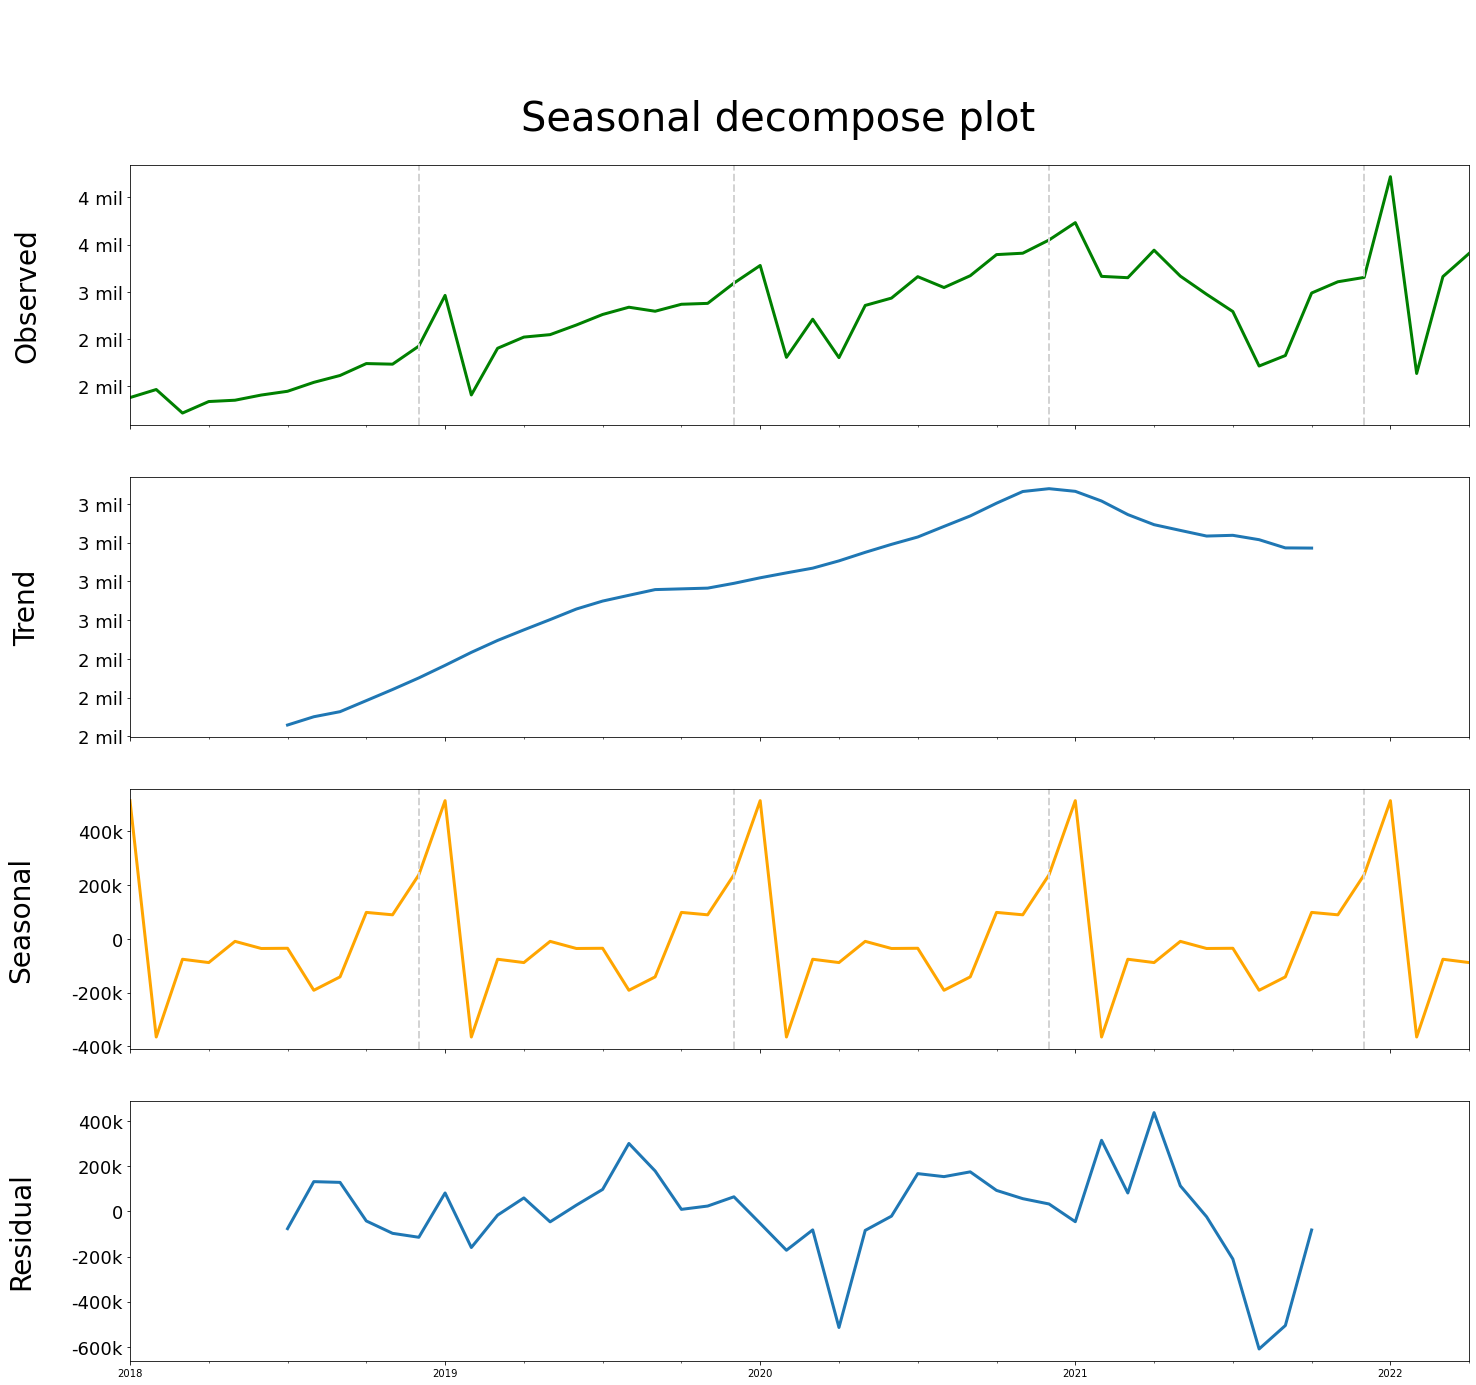

In [52]:
# visualize
plotseasonal(df_2prev.loc[:furthest_av, bank_name], model='additive', period=time_per)

**Visualizing differentiations and seasonal decompose after diff**

In [53]:
# function plotting 
def give_diff(df_org, column, diff_num):
    df = df_org.copy()

    fig, ax = plt.subplots(diff_num+2, 1, figsize=(20,17))
    add = ''
    for i in range(diff_num+2):
        ax[i].plot(df[column], linewidth=2.4, color='crimson')
        ax[i].xaxis.set_ticklabels([])
        # ax[i].yaxis.set_ticklabels([])
        ticks_loc = ax[i].get_yticks().tolist()
        ax[i].yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax[i].set_yticklabels([millify(x) for x in ticks_loc])
        if diff_num == -1:
            add = '(no parameter i found)'
        if i == diff_num+1:
            add = '(additional further diff - not required)'
        ax[i].set_title("Differentiation {} {}".format(i, add), size=20)
        if i == diff_num+1:
            break
        df.iloc[:f_index] = df.iloc[:f_index].diff().fillna(0)
    return df

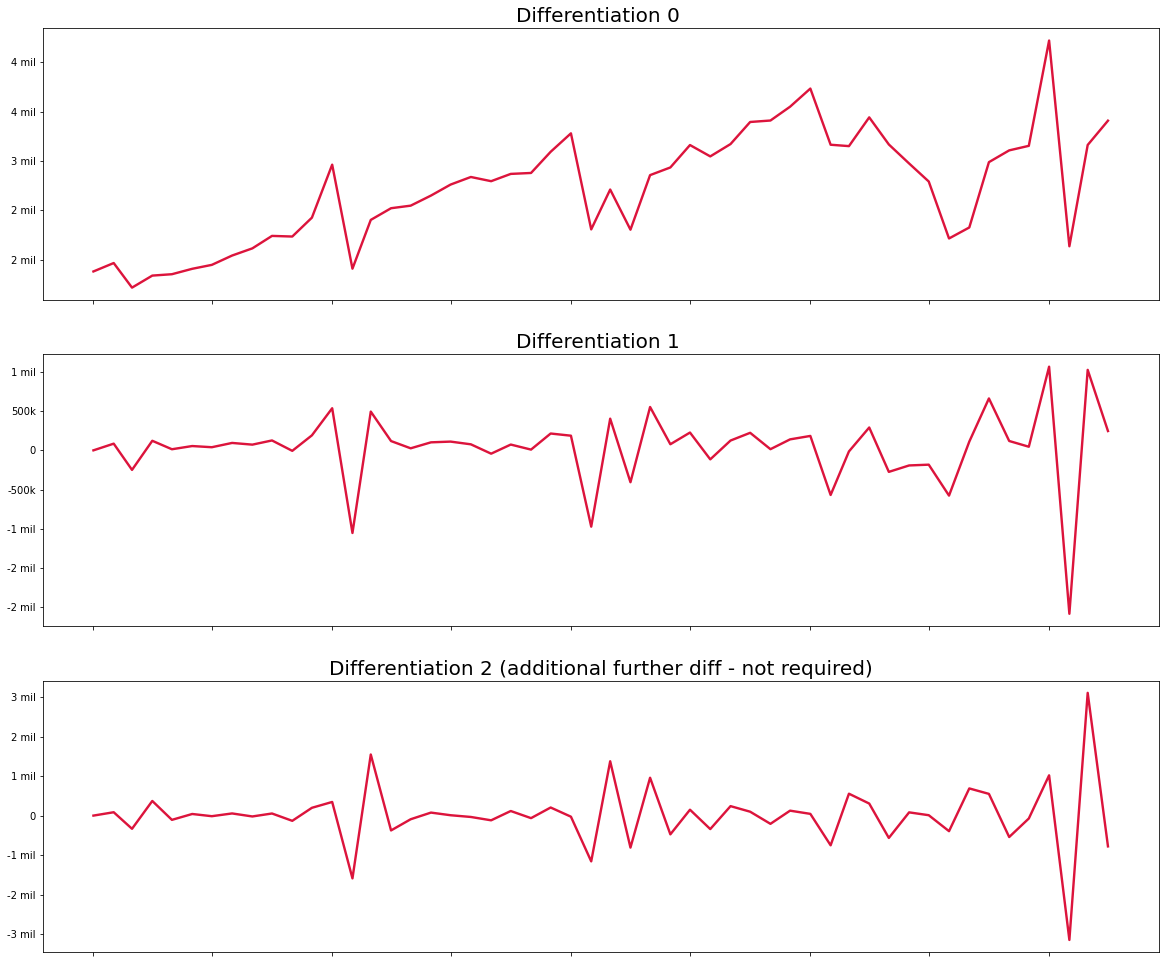

In [54]:
# plotting
df_diff_full = give_diff(df_2prev, bank_name, diff_num)

*Seasonal decompose after diff*

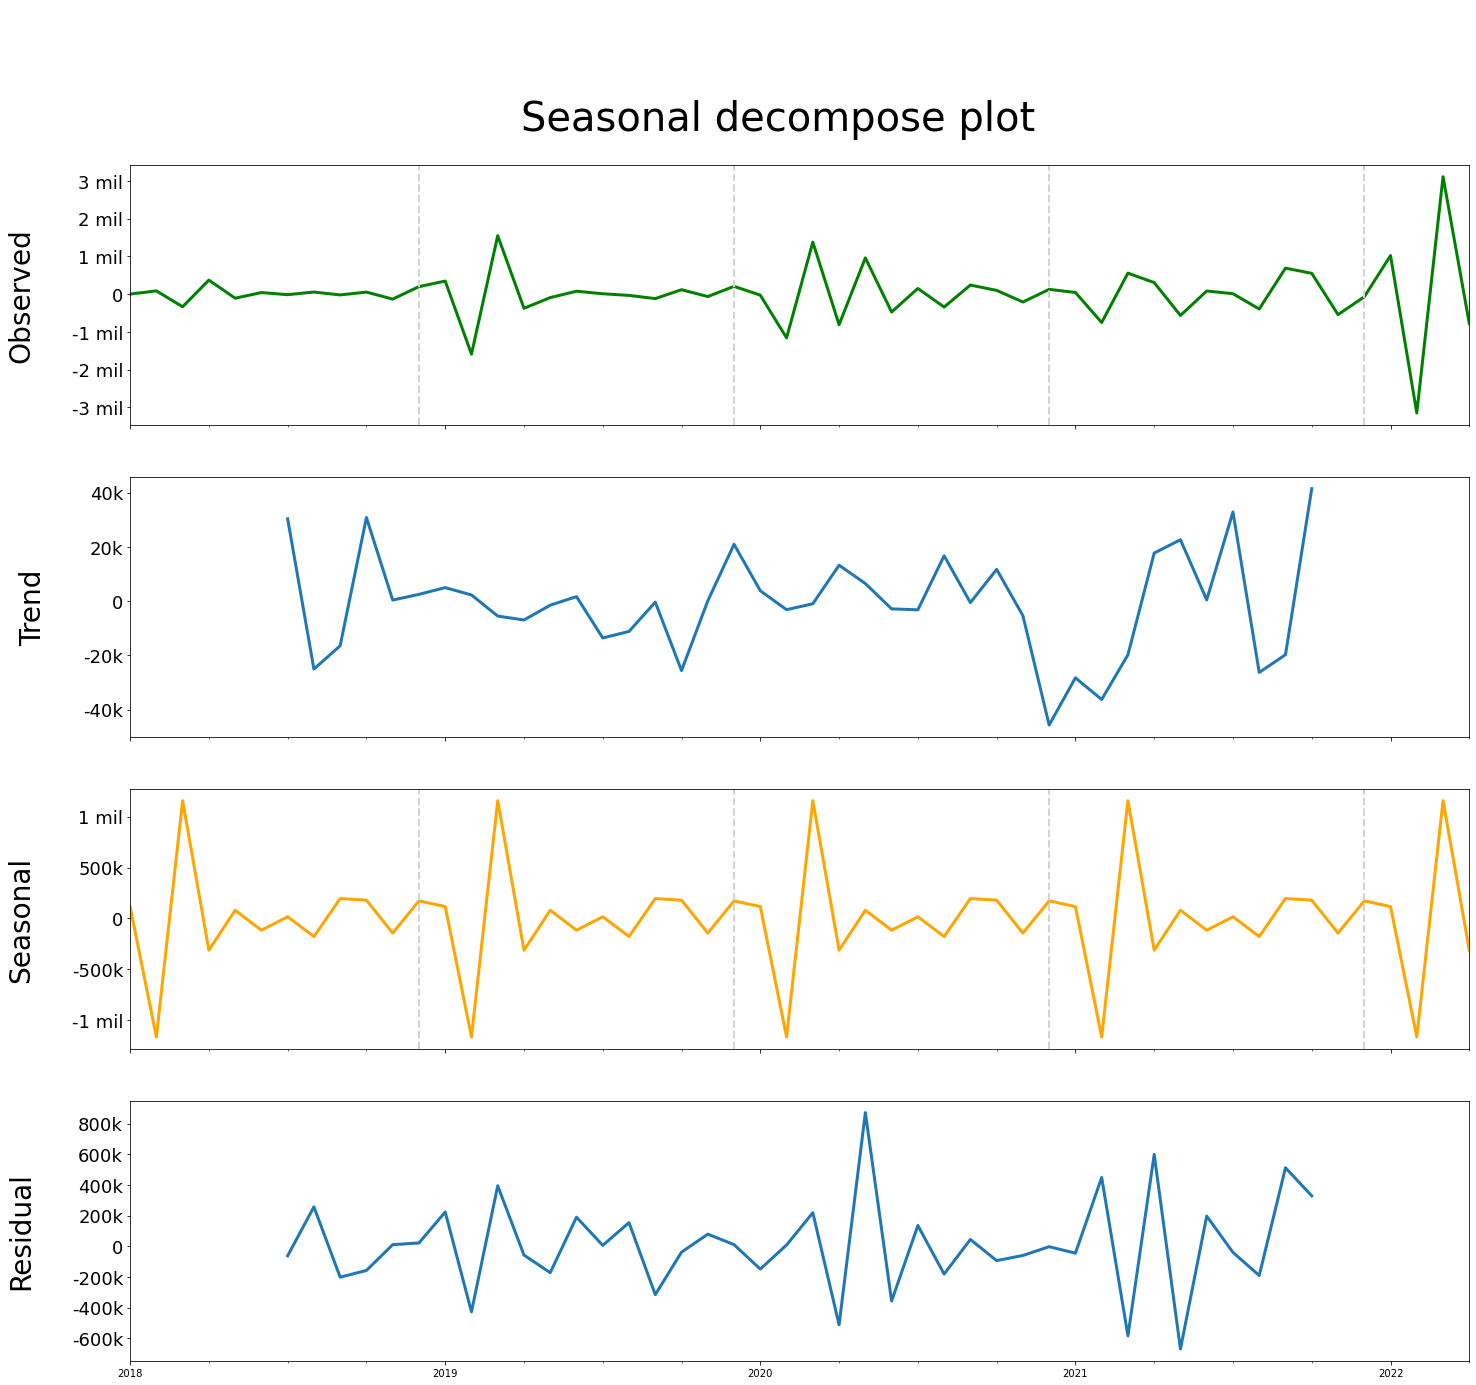

In [55]:
df_diff = df_diff_full.iloc[:f_index, :]
plotseasonal(df_diff[bank_name], model='additive', period=time_per)

### 2.2. Plotting PACF and ACF

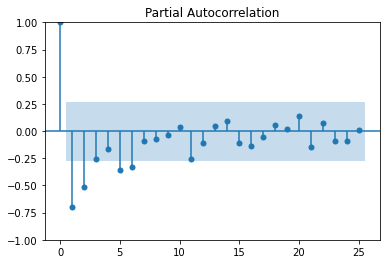

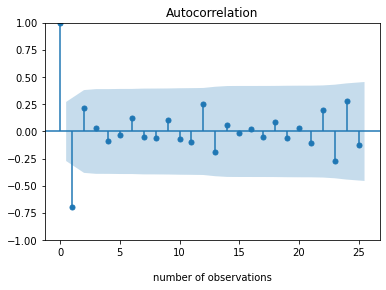

In [56]:
def plot_pacf_acf(df, column, lag_nums):
    pacf = plot_pacf(df[column], lags=lag_nums, method='ywm')
    acf = plot_acf(df[column], lags=lag_nums)
    plt.xlabel('\nnumber of observations')
    plt.show()

plot_pacf_acf(df_diff.fillna(0), bank_name, floor(len(df_diff.fillna(0))/2-1))

### 2.3. ARIMA model (more useful)

In [57]:
import statsmodels.api as sm

def ARIMA(df, column, p, i, q):
    if i == -1:
        i = 0
    testing_len = period_pred
    x = df[column].values
    train = x[:len(x)-testing_len]
    test = x[len(x)-testing_len:f_index]

    # Object Data type is accept all data-type
    Data_type = object 
    np.array(train, dtype = Data_type)

    # Build ARIMA model
    model = sm.tsa.arima.ARIMA(train,order=(p,i,q)).fit()

    # Making Predictions
    pred = model.predict(start = len(train), end=f_index-1,dynamic = False )
    future_pred = model.predict(start = len(train), end = len(x)-1,dynamic = False )

    # Plotting
    train_pred = np.concatenate((train, future_pred), axis=None)
    fig, ax = plt.subplots(figsize = (32,18))
    ax.plot(train_pred, color = 'b', label = 'predict', linewidth=4)
    ax.plot(x, color = 'r', label = 'real', linewidth=4)
    ax.plot(train, label = 'train', color = 'k', linewidth=4)
    beautify(df, ax, column, "ARIMA", i)
    plt.legend(prop={'size':30})
    plt.show()

    # rmse
    print("The rmse value is:", round(rmse(pred,test),0))

### *Change here*
Manual parameter change:
```
    ARIMA(df_2prev, bank_name, p, i, q)
```
**DO NOT CHANGE:**

        df_2prev
        bank_name
        i = diff_num

**ONLY EDIT THIS:**

        p:
            # change in accordance to 'Partial Autocorrelation' graph above:
              (starting from 0)
        q:
            # change in accordance to 'Autocorrelation' graph
              (starting from 0)
#### *Running ARIMA model*

/usr/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


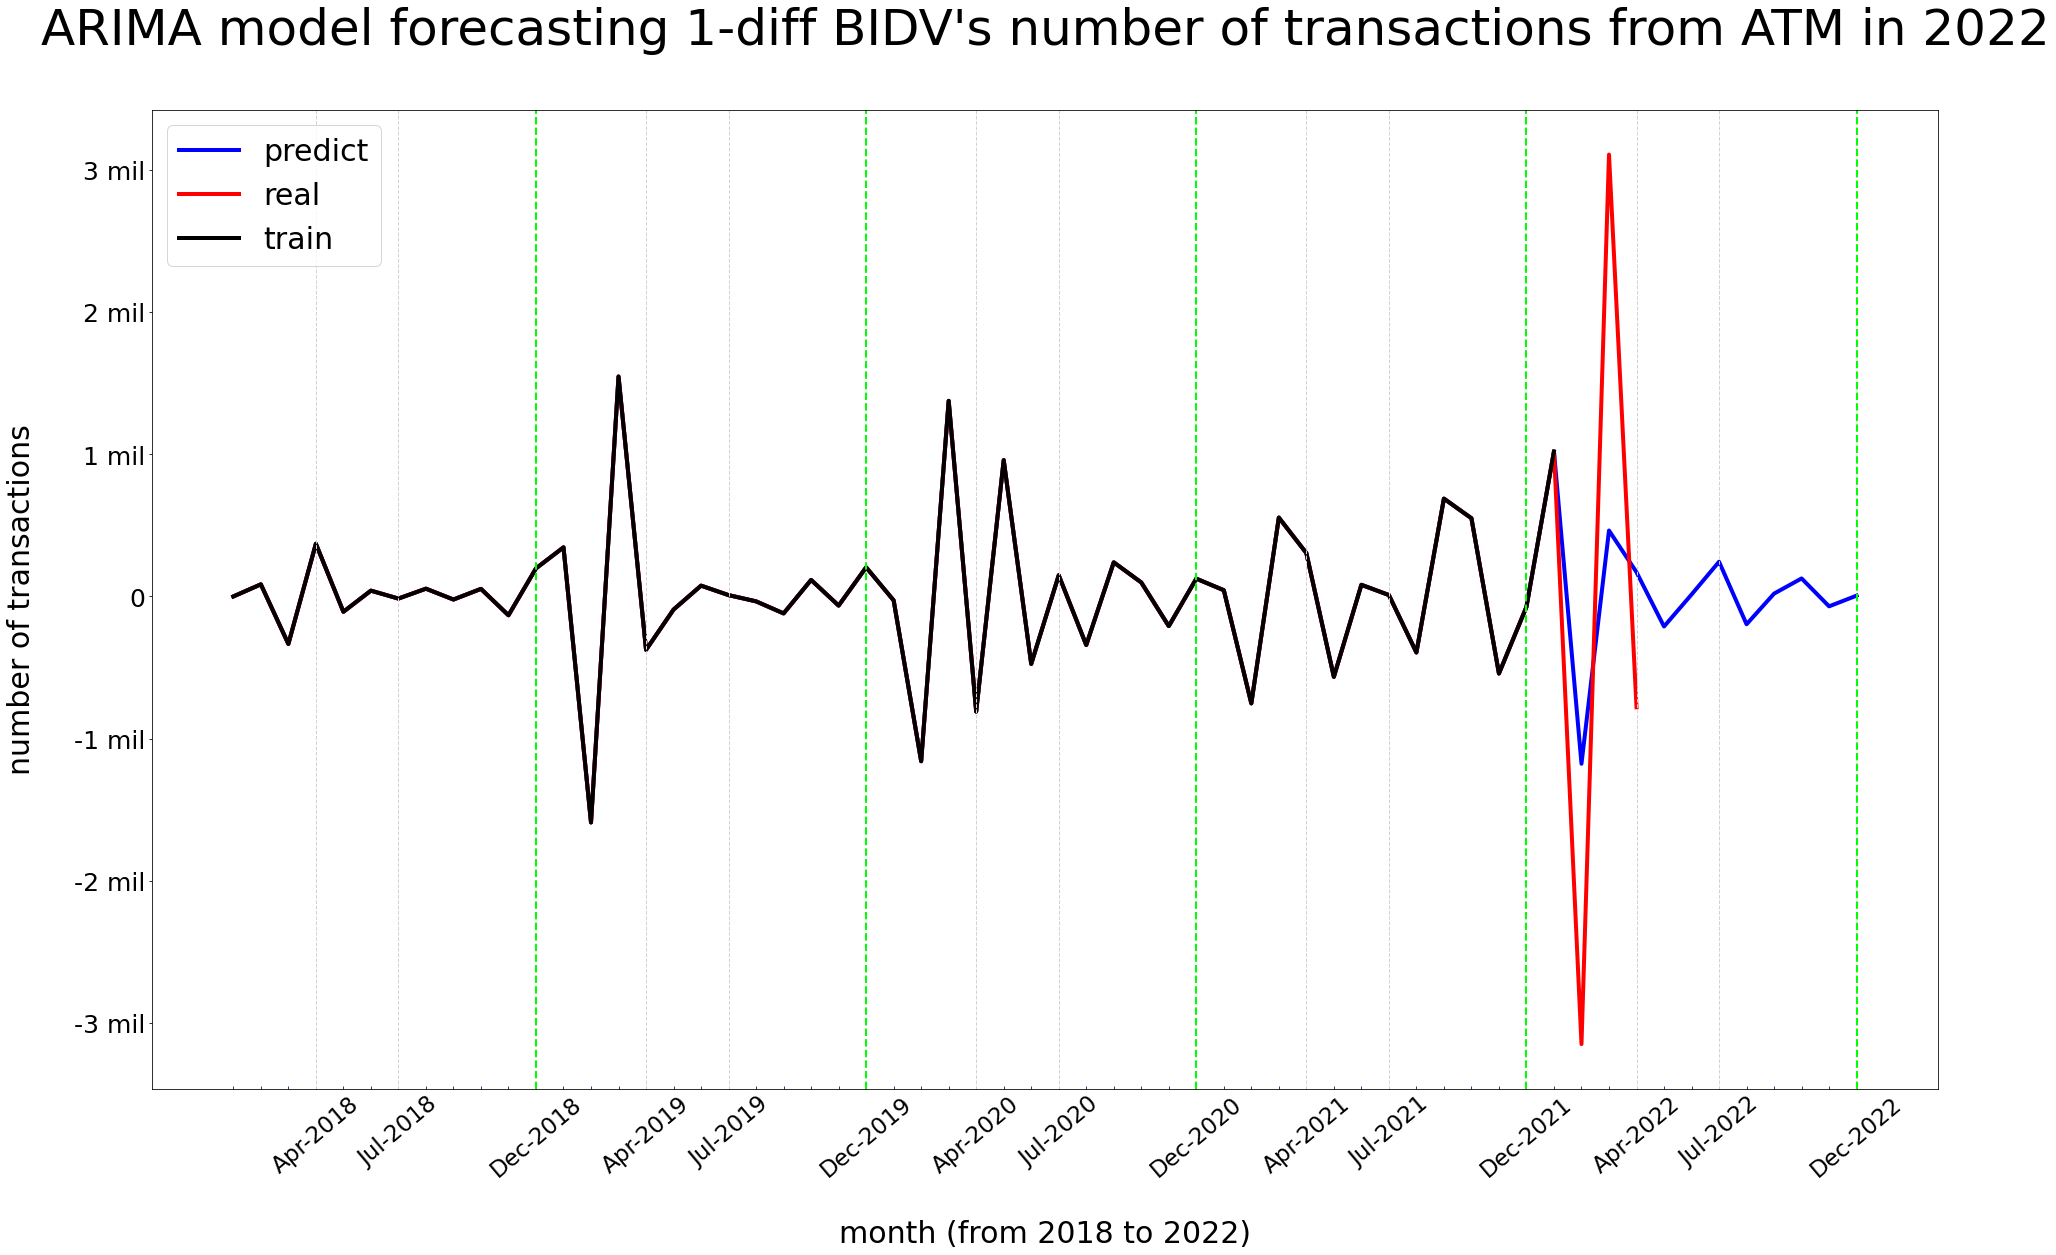

The rmse value is: 92557.0


In [81]:
# Manual parameter change:

ARIMA(df_diff_full, bank_name, p=6, i=diff_num, q=1)

## **3. Simple Moving Average (SMA)**
### (Only for visualizing and understanding trends, not for forecasting)

In [79]:
def df_SMAs(df, column):
    df_feature = df.iloc[:f_index+1,:].copy()
    df1 = df.iloc[:f_index+1,:].copy()
    df_feature = df_feature[[column]]
    df_feature['predict short SMA'] = df1[column].rolling(window=5).mean()
    df_feature['predict medium SMA'] = df1[column].rolling(window=10).mean()
    df_feature['predict long SMA'] = df1[column].rolling(window=20).mean()

    fig, ax = plt.subplots(figsize=(32,19))
    ax.plot(df_feature['predict short SMA'],
        label='predict short SMA', linestyle="-", color='blue', linewidth=4)
    ax.plot(df_feature['predict medium SMA'],
        label='predict medium SMA', linestyle="-", color='orange', linewidth=4)
    ax.plot(df_feature['predict long SMA'],
        label='predict long SMA', linestyle="-", color='cyan', linewidth=4)
    ax.plot(df1[column], label='True value', linestyle="--", color='k', linewidth=2)
    
    beautify(df1, ax, column, "SMA")
    plt.legend(prop={'size':22})
    plt.show()

    print("\n")
    print("+----------------------+")
    print("| Performance metrics: |")
    print("+----------------------+")

    #rmse_SMA
    rmse_short_SMA = rmse(df_feature['predict short SMA'], df_feature[column])
    #rmse_EMA
    rmse_medium_SMA = rmse(df_feature['predict medium SMA'], df_feature[column])
    #rmse_CMA
    rmse_long_SMA = rmse(df_feature['predict long SMA'], df_feature[column])

    print("  rmse_short_SMA: ", rmse_short_SMA)
    print("  rmse_medium_SMA:", rmse_medium_SMA)
    print("  rmse_long_SMA:  ", rmse_long_SMA)

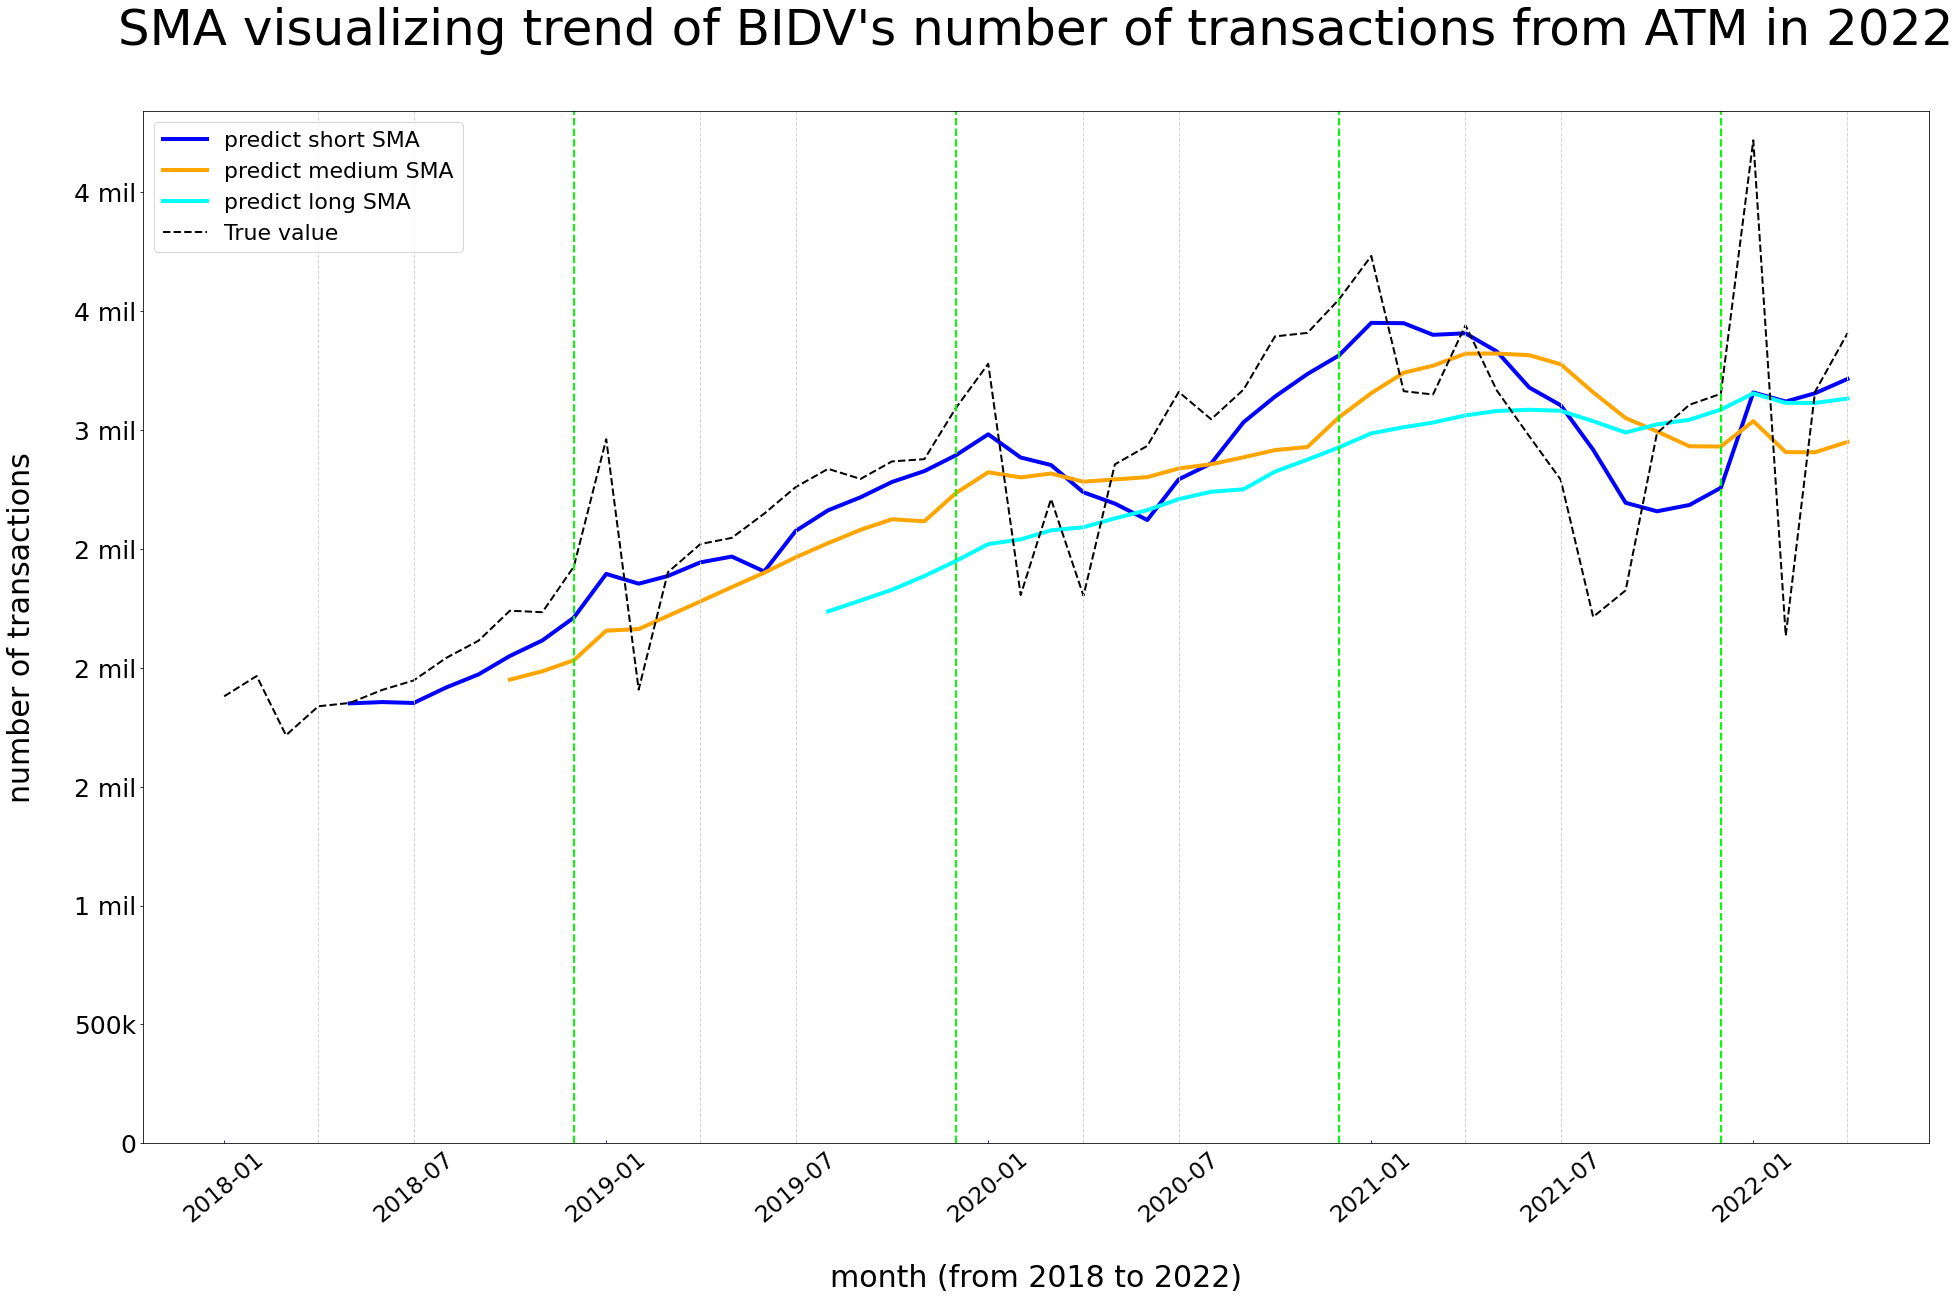



+----------------------+
| Performance metrics: |
+----------------------+
  rmse_short_SMA:  55365.12083333332
  rmse_medium_SMA: 121451.90697674421
  rmse_long_SMA:   201257.75757575757


In [80]:
df_SMAs(df_2prev, bank_name)